In [2]:
import sys
import time

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
# import seaborn as sns
# sns.set()
from sklearn import tree
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN

In [5]:
filenames = {
    "emulab_hdd_merged": "emulab_d460_10Gbps_hdd_merged_V2.csv",
    "emulab_hdd_unmerged": "emulab_d460_10Gbps_hdd_unmerged_V2.csv",

    "utah_ssd_merged": "utah_c6525-25g_25Gbps_ssd_merged_V2.csv",
    "utah_ssd_unmerged": "utah_c6525-25g_25Gbps_ssd_unmerged_V2.csv",

    "wisconsin_ssd_merged": "wisconsin_c220g1-10Gbps_ssd_merged_V2.csv",
    "wisconsin_ssd_unmerged": "wisconsin_c220g1-10Gbps_ssd_unmerged_V2.csv",

    "utah_ssd_merged_1g": "utah_c6525-25g_1Gbps_ssd_merged_V2.csv",
    "utah_ssd_unmerged_1g": "utah_c6525-25g_1Gbps_ssd_unmerged_V2.csv",

    "wisconsin_hdd_ssd_merged": "wisconsin_c220g1-10Gbps_hdd_ssd_merged_V2.csv",
    "wisconsin_hdd-ssd_unmerged": "wisconsin_c220g1-10Gbps_hdd_ssd_unmerged_V2.csv",

    "v2_utah_ssd_merged_1g": "tb4_v2_utah_c6525-25g_1Gbps_ssd_merged_V2.csv",
    "v2_utah_ssd_unmerged_1g": "tb4_v2_utah_c6525-25g_1Gbps_ssd_unmerged_V2.csv",
}


In [4]:
def model_factory(model_name):
    if model_name == "RandomForest":
        return RandomForestClassifier(n_estimators=100)
    elif model_name == "DecisionTreeClassifier":
        return DecisionTreeClassifier()
    elif model_name == "SVM":
        return  svm.SVC()
    elif model_name == "MLPNeuralNetwork":
        return MLPClassifier()
    elif model_name == "XGB":
        return XGBClassifier()
    else:
        return RandomForestClassifier(n_estimators=100)

In [6]:
emulab_hdd_merged = pd.read_csv(filenames.get('emulab_hdd_merged')).drop(['time_stamp'], axis=1)

wisconsin_ssd_merged = pd.read_csv(filenames.get('wisconsin_ssd_merged')).drop(['time_stamp'], axis=1)

emulab_hdd_unmerged = pd.read_csv(filenames.get('emulab_hdd_unmerged'))
wisconsin_ssd_unmerged = pd.read_csv(filenames.get('wisconsin_ssd_unmerged'))
utah_ssd_unmerged = pd.read_csv(filenames.get('utah_ssd_unmerged'))
v2_utah_ssd_unmerged_1g = pd.read_csv(filenames.get('v2_utah_ssd_unmerged_1g'))


In [ ]:
label = 18
df_chosen_label = wisconsin_ssd_unmerged[wisconsin_ssd_unmerged['label_value']==label]
# label_90[['sender_ost_read', 'sender_ost_write', 'sender_remote_ost_read_bytes', 'sender_remote_ost_write_bytes', 'receiver_ost_read', 'receiver_ost_write','receiver_remote_ost_read_bytes', 'receiver_remote_ost_write_bytes']]
pd.options.display.float_format = '{:.10f}'.format
df_chosen_label[['time_stamp','sender_retrans', 'sender_read_bytes', 'sender_write_bytes', 'sender_remote_ost_read_bytes', 'sender_remote_ost_write_bytes', 'receiver_read_bytes', 'receiver_write_bytes','receiver_remote_ost_read_bytes', 'receiver_remote_ost_write_bytes', 'receiver_write_bytes_io', 'through_put']]


In [34]:
def create_chart(x_range_max,x_tick_step,  MB_size,data_frame, title, metrics_to_label, ax2_metrics_to_label=None, ax2_label=None):
    from matplotlib import pyplot as plt
    sns.set_style("whitegrid")
    sns.set_palette("Set1")
    fig, ax = plt.subplots(figsize =(12, 5))
    x_range = np.arange(0, x_range_max , 1)
    lw=4
    ax.set_ylabel('Gbps', fontsize=33)
    ax.set_xlabel('Time (Second)', fontsize=33)

    lines = []
    max_lines = np.array([])
    for metric in metrics_to_label.keys():
        metric_name = metric
        metric_label = metrics_to_label[metric]
        line_i, = ax.plot(x_range, data_frame[metric_name].iloc[:x_range_max]/MB_size,'-', label=metric_label, linewidth=lw)
        max_lines = np.append (max_lines, np.max(data_frame[metric_name].iloc[:x_range_max]/MB_size))
        lines.append(line_i)
    plt.xticks(x_range[::x_tick_step],  fontsize=28)
    # plt.yticks(np.arange(0, 4, 1),  fontsize=28)
    # plt.yticks(np.arange(0, 15, 1),  fontsize=28)

    if np.rint(np.max(max_lines))==15:
        max = 15
        step = 3
    else:
        max = 5
        step = 1
    plt.yticks(np.arange(0, max , step),  fontsize=28)
    #ax2_metrics_to_label = {"ylabel": 'Sender\nsend value'}
    if ax2_metrics_to_label:
        ax2 = ax.twinx()
        ax2.grid(False)

        ax2.set_ylabel(ax2_label, fontsize=33)
        max_lines = np.array([])

        if ax2_metrics_to_label.get('sender_avg_send_value') or None:
            line_egress_bps, = ax2.plot(x_range, data_frame['sender_avg_send_value'].iloc[:x_range_max], label=ax2_metrics_to_label.get('sender_avg_send_value'), linewidth=lw, color='y')
            max_lines = np.append (max_lines, np.max(data_frame['sender_avg_send_value'].iloc[:x_range_max]))
            lines.append(line_egress_bps)
        if ax2_metrics_to_label.get('sender_retrans') or None:
            line_retrans, = ax2.plot(x_range, data_frame['sender_retrans'].iloc[:x_range_max], label=ax2_metrics_to_label.get('sender_retrans'), linewidth=lw, color='y')
            max_lines = np.append (max_lines, np.max(data_frame['sender_retrans'].iloc[:x_range_max]))
            lines.append(line_retrans)
        # if np.round(np.max(max_lines))>5000:
        #     max = 15
        #     step = 3
        # else:
        #     max = 5
        #     step = 1
        plt.yticks(np.arange(0, np.rint(np.max(max_lines)) + 1 , np.rint(np.max(max_lines)/4)),  fontsize=28)
    plt.legend(fontsize=28,ncol=2,  handles=lines, handlelength=0.7,  framealpha=0.8, loc='upper left', bbox_to_anchor=(0, 1.8))
    plt.title(title, fontsize=28)
    # return plt
    # plt.show()



In [8]:
def create_network_chart(x_range_max,x_tick_step,  MB_size,data_frame, title):

    from matplotlib import pyplot as plt
    sns.set_style("whitegrid")
    sns.set_palette("Set1")
    fig, ax = plt.subplots(figsize =(12, 5))
    x_range = np.arange(0, x_range_max , 1)
    lw=4
    ax.set_ylabel('Gbps', fontsize=33)
    ax.set_xlabel('Time (Second)', fontsize=33)
    line1, = ax.plot(x_range, data_frame['sender_read_bytes'].iloc[:x_range_max]/MB_size,'-', label="Sender App read", linewidth=lw)
    line2, = ax.plot(x_range, data_frame['sender_remote_ost_read_bytes'].iloc[:x_range_max]/MB_size,'-', label="Sender OSS read", linewidth=lw)

    line3, =ax.plot(x_range, data_frame['receiver_write_bytes'].iloc[:x_range_max]/MB_size,'-', label="Receiver App write", linewidth=lw)
    line4, = ax.plot(x_range, data_frame['receiver_remote_ost_write_bytes'].iloc[:x_range_max]/MB_size,'-', label="Receiver OSS write", linewidth=lw)
    # line5, = ax.plot(x_range, data_frame['receiver_write_bytes_io'].iloc[:x_range_max].diff().fillna(method='bfill')/MB_size,'-', label="Application write", linewidth=lw)
    if title == "Normal":
        line5, = ax.plot(x_range, data_frame['sender_dtn_read_bytes'].iloc[:x_range_max]/MB_size,'-', label="Sender DTN read", linewidth=lw)
        line6, = ax.plot(x_range, data_frame['receiver_dtn_write_bytes'].iloc[:x_range_max]/MB_size,'-', label="Receiver DTN write", linewidth=lw)

    line_t, = ax.plot(x_range, data_frame['Differences of Last value of write_bytes_io'].iloc[:x_range_max]/MB_size, label="Throughput", linewidth=lw, color='y')
    # line_t, = ax.plot(x_range, data_frame['through_put'].iloc[:x_range_max]/MB_size, label="Throughput", linewidth=lw, color='y')

    plt.xticks(x_range[::x_tick_step],  fontsize=28)
    plt.yticks(np.arange(0, 5, 1),  fontsize=28)
    ax2 = ax.twinx()
    ax2.grid(False)
    ax2.set_ylabel('Sender\nsend value', fontsize=33)
    line_retrans, = ax2.plot(x_range, data_frame['sender_avg_send_value'].iloc[:x_range_max], label="Sender Retransmissions", linewidth=lw, color='y')
    if title == "Normal":
        plt.legend(fontsize=28,ncol=2,  handles=[line1, line2, line3, line4, line5, line6, line_t, line_retrans], handlelength=0.7,  framealpha=0.8, loc='upper left', bbox_to_anchor=(0, 1.8))
    else:
        plt.legend(fontsize=28,ncol=2,  handles=[line1, line2, line3, line4, line_t, line_retrans], handlelength=0.7,  framealpha=0.8, loc='upper left', bbox_to_anchor=(0, 1.65))
    if np.max(data_frame['sender_avg_send_value'].iloc[:x_range_max]) > 5000:
        plt.yticks(np.arange(0, np.max(data_frame['sender_avg_send_value'].iloc[:x_range_max]),5000),  fontsize=28)
    else:
        plt.yticks(np.arange(0, 5000,1000),  fontsize=28)
    plt.title(title, fontsize=28)
    # return plt
    # plt.show()

In [10]:
# wisconsin_ssd_label_10
wisconsin_ssd_label_0 = pd.read_csv('congestions_data/0/wisconsin_c220g1-10Gbps_ssd_label_0.csv')

wisconsin_ssd_label_86 = pd.read_csv('congestions_data/86/wisconsin_c220g1-10Gbps_ssd_label_86.csv')
wisconsin_ssd_label_104 = pd.read_csv('congestions_data/104/wisconsin_c220g1-10Gbps_ssd_label_104.csv')

wisconsin_ssd_label_41 = pd.read_csv('congestions_data/41/wisconsin_c220g1-10Gbps_ssd_label_41.csv')
wisconsin_ssd_label_12 = pd.read_csv('congestions_data/12/wisconsin_c220g1-10Gbps_ssd_label_12.csv')

wisconsin_ssd_label_111 = pd.read_csv('congestions_data/111/wisconsin_c220g1-10Gbps_ssd_label_111.csv')
wisconsin_ssd_label_157 = pd.read_csv('congestions_data/157/wisconsin_c220g1-10Gbps_ssd_label_157.csv')


In [214]:
print(wisconsin_ssd_label_0['Differences of Last value of write_bytes_io'].mean()*8/1024/1024/1024)
print(wisconsin_ssd_label_104['Differences of Last value of write_bytes_io'].mean()*8/1024/1024/1024)
print(wisconsin_ssd_label_86['Differences of Last value of write_bytes_io'].mean()*8/1024/1024/1024)
print(wisconsin_ssd_label_41['Differences of Last value of write_bytes_io'].mean()*8/1024/1024/1024)
print(wisconsin_ssd_label_12['Differences of Last value of write_bytes_io'].mean()*8/1024/1024/1024)
print(wisconsin_ssd_label_157['Differences of Last value of write_bytes_io'].mean()*8/1024/1024/1024)
print(wisconsin_ssd_label_0['through_put'].mean())
print(wisconsin_ssd_label_104['through_put'].mean())
print(wisconsin_ssd_label_86['through_put'].mean())
print(wisconsin_ssd_label_41['through_put'].mean())
print(wisconsin_ssd_label_12['through_put'].mean())
print(wisconsin_ssd_label_157['through_put'].mean())

3.361223681219693
2.892731697328629
1.7585928501226964
0.6316958741645593
2.1784791492280506
0.8703318927304965


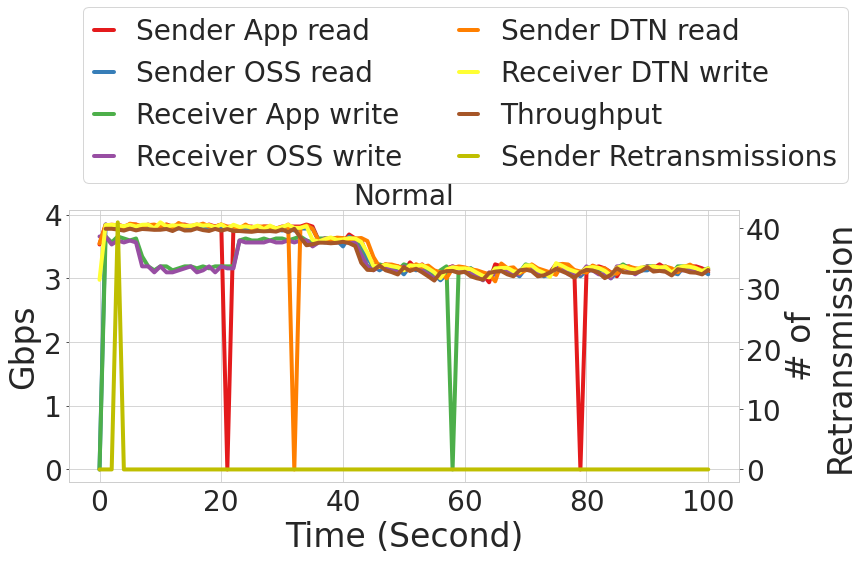

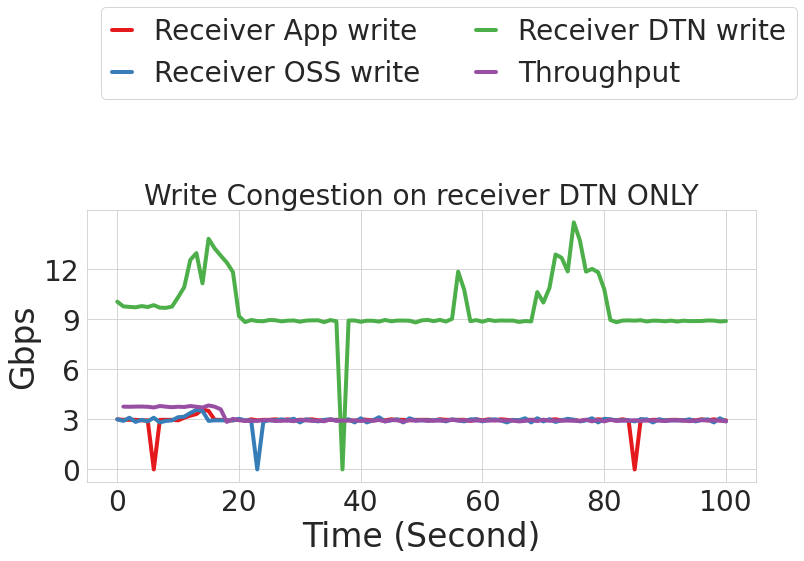

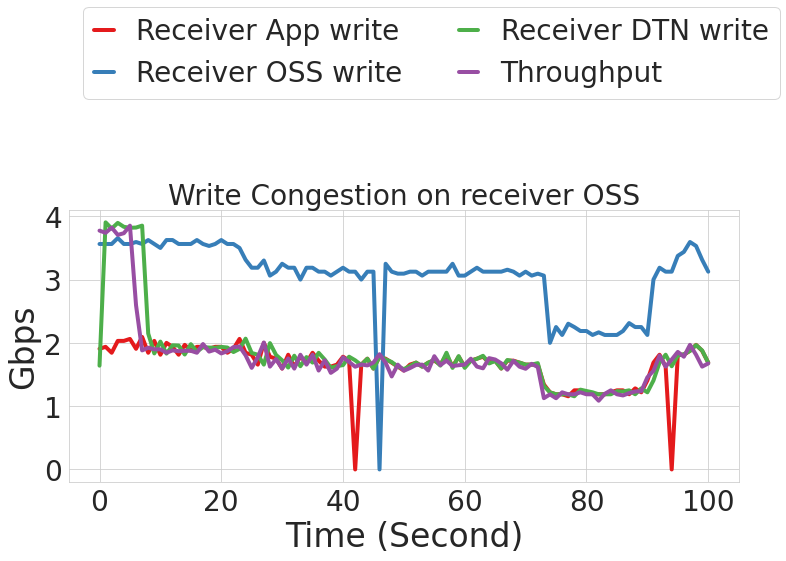

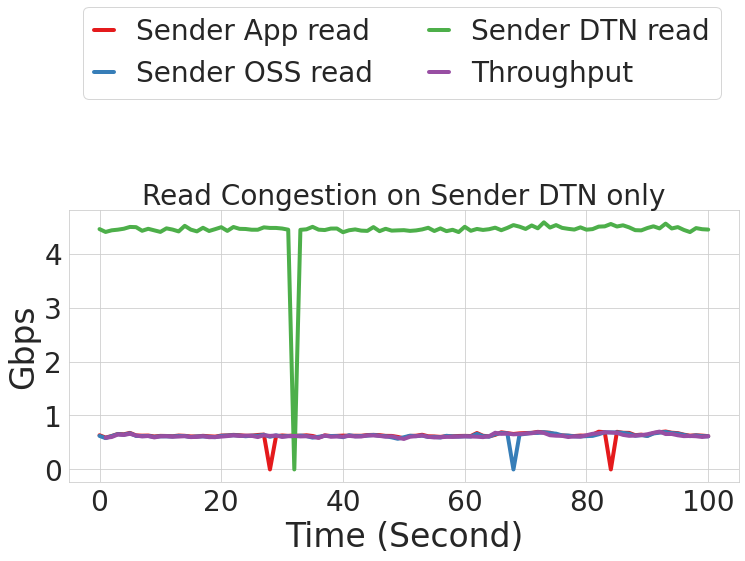

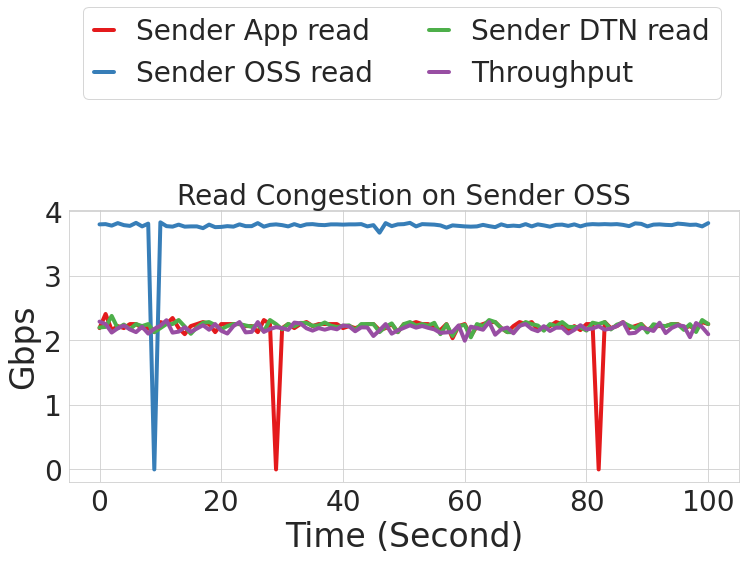

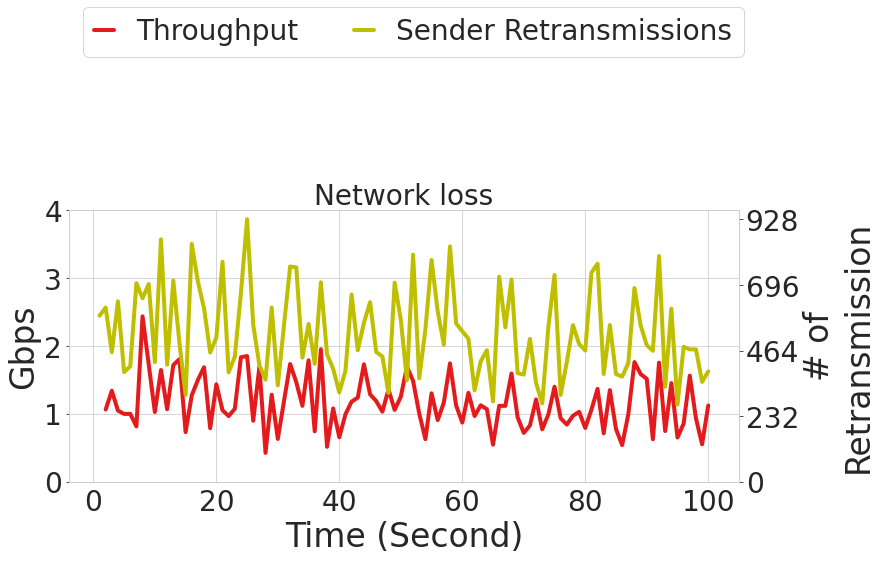

In [52]:
MB_size = 1024 * 1024 * 1024 / 8

# df_chosen = emulab_hdd_unmerged
df_chosen = wisconsin_ssd_unmerged
# df_chosen = utah_ssd_unmerged
# df_chosen = v2_utah_ssd_unmerged_1g

# Normal
# df_chosen_label_0 = df_chosen[df_chosen['label_value']==0]
df_chosen_label_0 = wisconsin_ssd_label_0

# write_congestion_by_receiver_on_other_ost
# df_chosen_label_108 = df_chosen[df_chosen['label_value']==108]
df_chosen_label_108 = wisconsin_ssd_label_104

# write_congestion_by_clients_on_receiver
# df_chosen_label_90 = df_chosen[df_chosen['label_value']==86]
df_chosen_label_90 = wisconsin_ssd_label_86


# read_congestion_by_sender_on_other_ost
# df_chosen_label_45 = df_chosen[df_chosen['label_value']==41]
df_chosen_label_45 = wisconsin_ssd_label_41

# read_congestion_by_clients_on_sender_OSS
# df_chosen_label_18 = df_chosen[df_chosen['label_value']==11]
df_chosen_label_18 = wisconsin_ssd_label_12

# network_anomaly_network_loss
# df_chosen_label_110 = df_chosen[df_chosen['label_value']==112]
df_chosen_label_110 = wisconsin_ssd_label_111
#
# network_anomaly_network_jitter
df_chosen_label_114 = df_chosen[df_chosen['label_value']==114]

#network_anomaly_network_corrupt
df_chosen_label_130 = df_chosen[df_chosen['label_value']==130]

# network_anomaly_network_reorder
df_chosen_label_142 = df_chosen[df_chosen['label_value']==142]

# network_anomaly_congestion
# df_chosen_label_159 = df_chosen[df_chosen['label_value']==158]
df_chosen_label_159 = wisconsin_ssd_label_157

time_range = 101
step = 20

metrics_to_draw = {'sender_read_bytes':'Sender App read', 'sender_remote_ost_read_bytes':'Sender OSS read',
 'receiver_write_bytes':'Receiver App write', 'receiver_remote_ost_write_bytes':'Receiver OSS write',
 'sender_dtn_read_bytes':'Sender DTN read', 'receiver_dtn_write_bytes':'Receiver DTN write',
                   'Differences of Last value of write_bytes_io': 'Throughput',}
# ax2_metrics_to_label = {'sender_avg_send_value': "Sender egresss Mbps"}# 'sender_retrans' : "Sender Retransmissions"
ax2_metrics_to_label = {'sender_retrans' : "Sender Retransmissions"  }#
create_chart(time_range, step, MB_size, df_chosen_label_0, title="Normal", metrics_to_label=metrics_to_draw, ax2_metrics_to_label=ax2_metrics_to_label, ax2_label="# of\nRetransmission")

# create_chart(time_range, step, MB_size, df_chosen_label_81, title="Write Congestion on receiver DTN and OSS")
metrics_to_draw = {'receiver_write_bytes':'Receiver App write', 'receiver_remote_ost_write_bytes':'Receiver OSS write',
 'receiver_dtn_write_bytes':'Receiver DTN write', 'Differences of Last value of write_bytes_io': 'Throughput'}
create_chart(time_range, step, MB_size, df_chosen_label_108, title="Write Congestion on receiver DTN ONLY", metrics_to_label=metrics_to_draw)

metrics_to_draw = {'receiver_write_bytes':'Receiver App write', 'receiver_remote_ost_write_bytes':'Receiver OSS write',
 'receiver_dtn_write_bytes':'Receiver DTN write', 'Differences of Last value of write_bytes_io': 'Throughput'}
create_chart(time_range, step, MB_size, df_chosen_label_90, title="Write Congestion on receiver OSS", metrics_to_label=metrics_to_draw) #

# create_chart(time_range, step, MB_size, df_chosen_label_9, title="Read Congestion on Sender DTN and OSS")
metrics_to_draw = {'sender_read_bytes':'Sender App read', 'sender_remote_ost_read_bytes':'Sender OSS read',
 'sender_dtn_read_bytes':'Sender DTN read', 'Differences of Last value of write_bytes_io': 'Throughput'}
create_chart(time_range, step, MB_size, df_chosen_label_45, title="Read Congestion on Sender DTN only", metrics_to_label=metrics_to_draw)

metrics_to_draw = {'sender_read_bytes':'Sender App read', 'sender_remote_ost_read_bytes':'Sender OSS read',
 'sender_dtn_read_bytes':'Sender DTN read', 'Differences of Last value of write_bytes_io': 'Throughput'}
create_chart(time_range, step, MB_size, df_chosen_label_18, title="Read Congestion on Sender OSS", metrics_to_label=metrics_to_draw)

metrics_to_draw = {'Differences of Last value of write_bytes_io': 'Throughput',}
# ax2_metrics_to_label = {'sender_avg_send_value': "Sender egresss Mbps"}# 'sender_retrans' : "Sender Retransmissions"
ax2_metrics_to_label = {'sender_retrans' : "Sender Retransmissions"  }
create_chart(time_range, step, MB_size, df_chosen_label_110, title="Network loss", metrics_to_label=metrics_to_draw, ax2_metrics_to_label=ax2_metrics_to_label, ax2_label="# of\nRetransmission")
# # create_network_chart(time_range, step, MB_size, df_chosen_label_114, title="Network jitter")
# # create_network_chart(time_range, step, MB_size, df_chosen_label_130, title="Network corrupt")
# # create_network_chart(time_range, step, MB_size, df_chosen_label_142, title="Network reorder")
# ax2_metrics_to_label = {'sender_avg_send_value': "Sender egresss Mbps"}
# create_chart(time_range, step, MB_size, df_chosen_label_159, title="Network Congesion", metrics_to_label=metrics_to_draw, ax2_metrics_to_label=ax2_metrics_to_label, ax2_label="")


KeyError: 'sender_dtn_read_bytes'

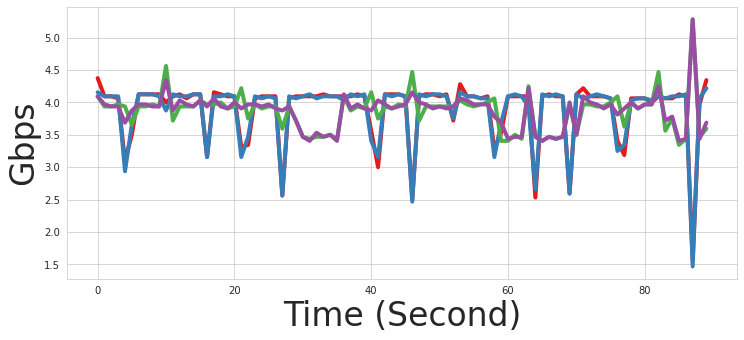

In [69]:
MB_size = 1024 * 1024 * 1024 / 8

# df_chosen = emulab_hdd_unmerged
df_chosen = wisconsin_ssd_unmerged
# df_chosen = utah_ssd_unmerged
# df_chosen = v2_utah_ssd_unmerged_1g
# Normal
df_chosen_label_0 = df_chosen[df_chosen['label_value']==0]

# write_congestion_by_receiver_on_receiver
df_chosen_label_81 = df_chosen[df_chosen['label_value']==81]

# write_congestion_by_receiver_on_other_ost
df_chosen_label_108 = df_chosen[df_chosen['label_value']==108]

# write_congestion_by_clients_on_receiver
# df_chosen_label_90 = df_chosen[df_chosen['label_value']==86]
df_chosen_label_90 = wisconsin_ssd_label_86


# read_congestion_by_sender_sender_ost
df_chosen_label_9 = df_chosen[df_chosen['label_value']==9]

# read_congestion_by_sender_on_other_ost
df_chosen_label_45 = df_chosen[df_chosen['label_value']==45]

# read_congestion_by_clients_on_sender_OSS
# df_chosen_label_18 = df_chosen[df_chosen['label_value']==11]
df_chosen_label_18 = wisconsin_ssd_label_10

# network_anomaly_network_loss
df_chosen_label_110 = df_chosen[df_chosen['label_value']==112]

# network_anomaly_network_jitter
df_chosen_label_114 = df_chosen[df_chosen['label_value']==114]

#network_anomaly_network_corrupt
df_chosen_label_130 = df_chosen[df_chosen['label_value']==130]

# network_anomaly_network_reorder
df_chosen_label_142 = df_chosen[df_chosen['label_value']==142]




data_frame = df_chosen_label_0
time_range = 90
step = 20

create_network_chart(time_range, step, MB_size, df_chosen_label_0, title="Normal")

# create_chart(time_range, step, MB_size, df_chosen_label_81, title="Write Congestion on receiver DTN and OSS")
create_chart(time_range, step, MB_size, df_chosen_label_108, title="Write Congestion on receiver DTN ONLY")
create_chart(time_range, step, MB_size, df_chosen_label_90, title="Write Congestion on receiver OSS") #

# create_chart(time_range, step, MB_size, df_chosen_label_9, title="Read Congestion on Sender DTN and OSS")
create_chart(time_range, step, MB_size, df_chosen_label_45, title="Read Congestion on Sender DTN only")
create_chart(time_range, step, MB_size, df_chosen_label_18, title="Read Congestion on Sender OSS")

# create_network_chart(time_range, step, MB_size, df_chosen_label_110, title="Network loss")
# create_network_chart(time_range, step, MB_size, df_chosen_label_114, title="Network jitter")
# create_network_chart(time_range, step, MB_size, df_chosen_label_130, title="Network corrupt")
# create_network_chart(time_range, step, MB_size, df_chosen_label_142, title="Network reorder")

In [ ]:
df = wisconsin_ssd_merged
# np.round((sum(sum((df == 0).values))) / (len(df) * len(df.columns)),3)
df.shape

In [ ]:
# df
len(dict(Counter(df[df.columns[len(df.columns) - 1]])))

In [ ]:
y = df.label_value
X = df.drop(columns="label_value") # df[features]
X_train, X_test, y_train, y_test = train_test_split(X,y)
print(X_train.shape)
# X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)
X_train, y_train = RandomOverSampler(sampling_strategy="all").fit_resample(X_train, y_train)
print(X_train.shape)
clf = RandomForestClassifier(n_estimators=100)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(np.round(metrics.accuracy_score(y_test, y_pred) * 100, 2))
# print(metrics.confusion_matrix(y_test, y_pred))
score = np.round(clf.feature_importances_, 2)

# print(sorted(list(score), reverse=True))
print("Cummulative Importance Score: \n", np.cumsum(sorted(list(score), reverse=True)))
print(Counter(score))

In [ ]:
features = []
for i in range(len(score)):
    if score[i] >= 0.02:
        features.append(X.columns[i])
        # print(df.columns[i])
print(features)
print(len(features))


In [ ]:
features = ['sender_avg_rtt_value', 'sender_cwnd_rate', 'sender_byte_ack', 'sender_seg_out', 'sender_retrans', 'sender_segs_in', 'sender_avg_send_value', 'sender_tcp_snd_buffer_min', 'sender_tcp_snd_buffer_max', 'sender_req_waittime', 'sender_req_active', 'sender_read_bytes', 'sender_ost_read', 'sender_ost_write', 'sender_avg_waittime_md', 'sender_system_cpu_percent', 'sender_remote_ost_read_bytes', 'sender_remote_ost_write_bytes', 'receiver_seg_out', 'receiver_segs_in', 'receiver_req_waittime', 'receiver_req_active', 'receiver_write_bytes', 'receiver_ost_write', 'receiver_avg_waittime_md', 'receiver_system_cpu_percent', 'receiver_remote_ost_read_bytes', 'receiver_remote_ost_write_bytes']

# features =  ['sender_avg_rtt_value', 'sender_retrans','sender_segs_in', 'sender_seg_out', 'sender_req_waittime', 'sender_read_bytes', 'sender_write_bytes', 'sender_avg_waittime_md', 'sender_ost_read' , 'sender_ost_write','sender_remote_ost_read_bytes', 'sender_remote_ost_write_bytes','receiver_segs_in','receiver_seg_out', 'receiver_req_waittime', 'receiver_read_bytes', 'receiver_write_bytes', 'receiver_ost_read', 'receiver_ost_write', 'receiver_avg_waittime_md', 'receiver_remote_ost_read_bytes', 'receiver_remote_ost_write_bytes']

In [ ]:
len (features_3)

In [ ]:
y_new = df.label_value
X_new = df[features] #.drop(columns="label_value")
X_train, X_test, y_train, y_test = train_test_split(X_new,y_new)
print(X_train.shape)
# X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)
X_train, y_train = RandomOverSampler(sampling_strategy="all").fit_resample(X_train, y_train)

print(X_train.shape)
clf_new = RandomForestClassifier(n_estimators=100)
# clf = make_pipeline(StandardScaler(), SVC())
# clf = SVC()
clf_new.fit(X_train, y_train)
y_pred = clf_new.predict(X_test)
print(np.round(metrics.f1_score(y_test, y_pred, average='weighted') * 100, 2))

In [ ]:

# def update_labels_xgboost(df):
#     updated_labels = {0:0, 1:1, 10:2, 19:3, 28:4, 37:5,
#                       46:6, 55:7, 64:8, 73:9, 82:10, 91:11,
#                       100:12, 109:13, 113:14, 117:15, 129:16,
#                       133:17, 145:18, 151:19, 157:20}
#     y = [updated_labels[int(i)] for i in df[df.columns[len(df.columns) - 1]].values]
#     df["label_value"] = y
#     return df
# [ 91, 100, 46]
def update_labels_xgboost(df):
    updated_labels = {0:0, 1:1, 10:2, 19:3, 28:4, 37:5,
                      55:6, 64:7, 73:8, 82:9,
                     109:10, 113:11, 117:12, 129:13,
                      133:14, 145:15, 151:16, 157:17}
    y = [updated_labels[int(i)] for i in df[df.columns[len(df.columns) - 1]].values]
    df["label_value"] = y
    return df

## TEST WITH DIFFERENT CLASSIFIRES MEREGD LEVELS - 21 labels

In [ ]:
datasets = ['emulab_hdd_merged', 'utah_ssd_merged', 'wisconsin_ssd_merged', 'utah_ssd_merged_1g', 'wisconsin_hdd_ssd_merged']
classifiers = {"RandomForest": RandomForestClassifier(n_estimators=100),
           "DecisionTreeClassifier": DecisionTreeClassifier(),
           "SVM": svm.SVC(),
           "MLPNeuralNetwork": MLPClassifier(),
           "XGB": XGBClassifier(),
        }
classifiers_legends = list(classifiers.keys())
all_accuracies = {}
round_number = 3
training_time = {}
remove_labels = [ 91, 100, 46]
import time
for clf_key in classifiers:
    accuracies = np.zeros(len(datasets))
    for i in range(round_number):
        temp_acc = np.array([])
        for key in datasets:
            print("run {} model for dataset: {}".format(clf_key.replace("\n", " "), key))
            df = pd.read_csv(filenames.get(key)).drop(['time_stamp', 'through_put'], axis=1)
            df = remove_labels_in_df(df, remove_labels)
            if clf_key == "XGB":
                df = update_labels_xgboost(df)
            y = df.label_value
            X = df.drop(columns="label_value")[features] # df[features]
            X_train, X_test, y_train, y_test = train_test_split(X,y)
            # print(X_train.shape)
            # X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)
            X_train, y_train = RandomOverSampler(sampling_strategy="all").fit_resample(X_train, y_train)
            # print(X_train.shape)
            # clf = classifiers[clf_key]
            clf = model_factory(clf_key)
            clf = make_pipeline(StandardScaler(), clf)
            time_1 = time.time()
            clf.fit(X_train, y_train)
            time_2 = time.time()
            if training_time.get(clf_key):
                training_time.get(clf_key).append(time_2-time_1)
            else:
                training_time[clf_key] = [time_2-time_1]
            y_pred = clf.predict(X_test)
            accuracy = np.round(metrics.f1_score(y_test, y_pred, average='weighted') * 100, 2)
            temp_acc = np.append(temp_acc, accuracy)
        accuracies = np.add(accuracies, temp_acc)
    print("\n")
    accuracies = accuracies / round_number
    all_accuracies[clf_key] = accuracies

print(classifiers_legends)
print(datasets)
print(all_accuracies)
print(training_time)

In [ ]:
_21_labels_accs = all_accuracies
# {'RandomForest': array([95.614, 98.944, 97.074, 98.776, 97.536]), 'DecisionTreeClassifier': array([93.648, 97.23 , 94.22 , 98.36 , 96.126]), 'SVM': array([85.86 , 94.902, 93.404, 90.852, 94.856]), 'MLPNeuralNetwork': array([91.064, 97.82 , 95.668, 95.564, 97.388]), 'XGB': array([98.344, 98.768, 97.522, 99.07 , 98.042])}
# all_accuracies = {'RandomForest': np.array([95.68, 99.12, 97.39, 98.81, 96.98]), 'DecisionTreeClassifier': np.array([93.38, 97.37, 94.46, 97.6 , 95.75]), 'SVM': np.array([85.89, 95.33, 93.42, 90.31, 94.56]), 'MLPNeuralNetwork': np.array([91.45, 98.17, 95.62, 95.07, 97.75]), 'XGB': np.array([97.92, 98.83, 97.64, 99.33, 97.79])}

# with over smapling
# {'RandomForest': np.array([98.56, 99.85, 99.12, 99.82, 99.07]), 'DecisionTreeClassifier': np.array([97.29, 99.28, 97.99, 99.81, 98.32]), 'SVM': np.array([90.73, 98.46, 96.61, 98.3 , 97.69]), 'MLPNeuralNetwork': np.array([98.7 , 99.74, 98.26, 99.27, 98.98]), 'XGB': np.array([99.7 , 99.76, 99.41, 99.94, 99.01])}

#remove labels
# {'RandomForest': array([98.38666667, 99.80333333, 99.63666667, 99.86      , 99.09      ]), 'DecisionTreeClassifier': array([97.43      , 99.26      , 97.97666667, 99.88      , 98.04      ]), 'SVM': array([94.1       , 99.13      , 97.86333333, 99.52      , 97.58333333]), 'MLPNeuralNetwork': array([98.23666667, 99.70333333, 99.34      , 99.68333333, 99.08333333]), 'XGB': array([99.67333333, 99.77333333, 99.72      , 99.90666667, 99.26333333])}

In [ ]:
# np.average([95.68, 99.12, 97.39, 98.81, 96.98])
# np.average([97.92, 98.83, 97.64, 99.33, 97.79])
# print(np.average([0.7868380546569824, 0.417910099029541, 0.35545897483825684, 0.34842419624328613, 0.354356050491333]))
# print(np.average([2.951751232147217, 1.601038932800293, 1.7936930656433105, 1.8401007652282715, 1.371891975402832]))
# accs = {'RandomForest': np.array([98.38666667, 99.80333333, 99.63666667, 99.86      , 99.09      ]), 'DecisionTreeClassifier': np.array([97.43      , 99.26      , 97.97666667, 99.88      , 98.04      ]), 'SVM': np.array([94.1       , 99.13      , 97.86333333, 99.52      , 97.58333333]), 'MLPNeuralNetwork': np.array([98.23666667, 99.70333333, 99.34      , 99.68333333, 99.08333333]), 'XGB': np.array([99.67333333, 99.77333333, 99.72      , 99.90666667, 99.26333333])}
#
# for key in accs.keys():
#     print(key, np.round(accs[key], 2))

In [ ]:
plt.rcParams.update({'font.size': 14})
# Figure Size
fig, ax = plt.subplots(figsize =(8, 3), dpi=160)
barWidth = 0.15

# Set position of bar on X axis
br1 = np.arange(len(datasets))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]

ax.grid(visible = True, axis='y', color ='grey', linestyle ='--', linewidth = 0.5, alpha = 0.4)
ax.set_ylabel('F1-Score %')
ax.set_ylim(ymin=65, ymax=102)


ax.bar(br1, all_accuracies['RandomForest'], width = barWidth, edgecolor ='black', label="RandomForest")
ax.bar(br2, all_accuracies['DecisionTreeClassifier'], width = barWidth, edgecolor ='black', label="DecisionTreeClassifier",)
ax.bar(br3, all_accuracies['SVM'], width = barWidth, edgecolor ='black', label="SVM", )
ax.bar(br4, all_accuracies['MLPNeuralNetwork'], width = barWidth, edgecolor ='black', label="MLPNeuralNetwork")
ax.bar(br5, all_accuracies['XGB'], width = barWidth, edgecolor ='black', label="XGB")


plt.xlabel('Dataset', fontweight ='bold')
plt.yticks(np.arange(65, 101, 5))
xticks = ['Testbed#1', 'Testbed#2', 'Testbed#3', 'Testbed#4', 'Testbed#5']
plt.xticks([r + 0.3 for r in range(len(br1))], xticks, rotation=10)

plt.legend(fontsize = 9, loc='lower right')
plt.savefig("21_labels_accuracies.pdf", bbox_inches='tight')

## TEST WITH DIFFERENT CLASSIFIRES UNMERGED LEVELS - 161 labels

In [ ]:
# df = pd.read_csv(filenames.get('emulab_hdd_unmerged')).drop(['time_stamp', 'through_put'], axis=1)
df = pd.read_csv(filenames.get('wisconsin_ssd_unmerged')).drop(['time_stamp', 'through_put'], axis=1)
print(df.shape)
print(len(dict(Counter(df[df.columns[len(df.columns) - 1]]))))
y = df.label_value
X = df.drop(columns="label_value")[features_2] # df[features]
# X = df.drop(columns="label_value")[features] # df[features]
# X = df.drop(columns="label_value") # df[features]
X_train, X_test, y_train, y_test = train_test_split(X,y)
# print(X_train.shape)
# X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)
X_train, y_train = RandomOverSampler(sampling_strategy="all").fit_resample(X_train, y_train)
print(X_train.shape)
clf = RandomForestClassifier(n_estimators=100)
# clf = make_pipeline(StandardScaler(), SVC())
# clf = SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(np.round(metrics.accuracy_score(y_test, y_pred) * 100, 2))
score = np.round(clf.feature_importances_, 2)
# print(sorted(list(score), reverse=True))
print("Cummulative Importance Score: \n", np.cumsum(sorted(list(score), reverse=True)))
print(Counter(score))
# features_2 = []
# for i in range(len(score)):
#     if score[i] >= 0.02:
#         features_2.append(X.columns[i])
#         # print(df.columns[i])
# print(features_2)
# print(len(features_2))

In [ ]:
# features_2 =['sender_avg_rtt_value', 'sender_cwnd_rate', 'sender_seg_out', 'sender_ssthresh_value', 'sender_segs_in', 'sender_avg_send_value', 'sender_vsize', 'sender_rss', 'sender_mem_usage_percentage', 'sender_avg_waittime_md', 'sender_system_cpu_percent', 'receiver_seg_out', 'receiver_segs_in', 'receiver_read_bytes_io', 'receiver_vsize', 'receiver_rss', 'receiver_mem_usage_percentage', 'receiver_req_active', 'receiver_avg_waittime_md', 'receiver_system_cpu_percent']
features_2 = ['sender_avg_rtt_value', 'sender_pacing_rate', 'sender_cwnd_rate', 'sender_byte_ack', 'sender_seg_out', 'sender_retrans', 'sender_ssthresh_value', 'sender_segs_in', 'sender_avg_send_value', 'sender_vsize', 'sender_rss', 'sender_mem_usage_percentage', 'sender_req_waittime', 'sender_req_active', 'sender_ost_read', 'sender_avg_waittime_md', 'sender_system_cpu_percent', 'sender_remote_ost_read_bytes', 'receiver_seg_out', 'receiver_segs_in', 'receiver_read_bytes_io', 'receiver_vsize', 'receiver_rss', 'receiver_mem_usage_percentage', 'receiver_req_waittime', 'receiver_req_active', 'receiver_write_bytes', 'receiver_ost_write', 'receiver_avg_waittime_md', 'receiver_system_cpu_percent', 'receiver_remote_ost_write_bytes']

In [ ]:
def update_labels_xgboost_161_labels(df):
    #[ 91, 100, 46]
    updated_labels = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45,

    55: 46, 56: 47, 57: 48, 58: 49, 59: 50, 60: 51, 61: 52, 62: 53, 63: 54, 64: 55, 65: 56, 66: 57, 67: 58, 68: 59, 69: 60, 70: 61, 71: 62, 72: 63, 73: 64, 74: 65, 75: 66, 76: 67, 77: 68, 78: 69, 79: 70, 80: 71, 81: 72, 82: 73, 83: 74, 84: 75, 85: 76, 86: 77, 87: 78, 88: 79, 89: 80, 90: 81,

    109: 82, 110: 83, 111: 84, 112: 85, 113: 86, 114: 87, 115: 88, 116: 89, 117: 90, 118: 91, 119: 92, 120: 93, 121: 94, 122: 95, 123: 96, 124: 97, 125: 98, 126: 99, 127: 100, 128: 101, 129: 102, 130: 103, 131: 104, 132: 105, 133: 106, 134: 107, 135: 108, 136: 109, 137: 110, 138: 111, 139: 112, 140: 113, 141: 114, 142: 115, 143: 116, 144: 117, 145: 118, 146: 119, 147: 120, 148: 121, 149: 122, 150: 123, 151: 124, 152: 125, 153: 126, 154: 127, 155: 128, 156: 129, 157: 130, 158: 131, 159: 132, 160: 133
    }
    y = [updated_labels[int(i)] for i in df[df.columns[len(df.columns) - 1]].values]
    df["label_value"] = y
    return df

In [ ]:
datasets = ['emulab_hdd_unmerged', 'utah_ssd_unmerged', 'wisconsin_ssd_unmerged', 'utah_ssd_unmerged_1g', 'wisconsin_hdd-ssd_unmerged']
# datasets = ['utah_ssd_unmerged_1g']
classifiers = {"RandomForest": RandomForestClassifier(n_estimators=100),
           "DecisionTreeClassifier": DecisionTreeClassifier(),
           "SVM": svm.SVC(),
           "MLPNeuralNetwork": MLPClassifier(),
           "XGB": XGBClassifier(),
        }
classifiers_legends = list(classifiers.keys())
all_accuracies = {}
round_number = 3
remove_labels = [ 91,92, 93, 94, 95,96, 97,98, 99,
                  100, 101, 102, 103, 104, 105, 106, 107, 108,
                  46, 47, 48, 49, 50, 51, 52, 53, 54 ]
for clf_key in classifiers:
    accuracies = np.zeros(len(datasets))
    for i in range(round_number):
        temp_acc = np.array([])
        for key in datasets:
            print("run {} model for dataset: {}".format(clf_key.replace("\n", " "), key))
            df = pd.read_csv(filenames.get(key)).drop(['time_stamp', 'through_put'], axis=1)
            df = remove_labels_in_df(df, remove_labels)
            if clf_key == "XGB":
                df = update_labels_xgboost_161_labels(df)
            y = df.label_value
            X = df.drop(columns="label_value")[features_2]#[features] # df[features]
            X_train, X_test, y_train, y_test = train_test_split(X,y)
            # print(X_train.shape)
            # X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)
            X_train, y_train = RandomOverSampler(sampling_strategy="all").fit_resample(X_train, y_train)
            # print(X_train.shape)
            # clf = classifiers[clf_key]
            clf = model_factory(clf_key)
            clf = make_pipeline(StandardScaler(), clf)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accuracy = np.round(metrics.f1_score(y_test, y_pred, average='weighted') * 100, 2)
            print(accuracy)
            temp_acc = np.append(temp_acc, accuracy)
        accuracies = np.add(accuracies, temp_acc)
    print("\n")
    accuracies = accuracies / round_number
    all_accuracies[clf_key] = accuracies

print(classifiers_legends)
print(datasets)
print(all_accuracies)

In [ ]:
_161_labels_accs = all_accuracies

# all_accuracies = {'RandomForest': np.array([95.844, 94.296, 92.704, 96.604, 93.946]), 'DecisionTreeClassifier': np.array([85.112, 86.942, 78.36 , 91.38 , 81.472]), 'SVM': np.array([85.55 , 76.662, 70.888, 70.622, 73.66 ]), 'MLPNeuralNetwork': np.array([94.842, 89.602, 88.69 , 88.97 , 92.44 ]), 'XGB': np.array([94.798, 92.164, 90.5  , 95.022, 91.802])}

#with over sampling
# {'RandomForest': np.array([95.07, 94.94, 93.06, 97.32, 94.3 ]), 'DecisionTreeClassifier': np.array([85.41, 89.98, 82.11, 93.27, 84.59]), 'SVM': np.array([84.9 , 82.67, 72.54, 80.11, 74.87]), 'MLPNeuralNetwork': np.array([95.88, 92.7 , 92.77, 94.61, 94.97]), 'XGB': np.array([94.62, 92.07, 90.77, 94.31, 92.17])}
accs = {'RandomForest': np.array([94.81333333, 94.56      , 93.09666667, 96.60666667, 93.54666667]), 'DecisionTreeClassifier': np.array([86.49333333, 90.98666667, 84.11666667, 94.25      , 85.81333333]), 'SVM': np.array([86.65666667, 83.91333333, 76.73666667, 78.77333333, 77.96666667]), 'MLPNeuralNetwork': np.array([96.45333333, 93.56333333, 93.73666667, 93.91      , 95.46666667]), 'XGB': np.array([94.86      , 93.09666667, 92.39333333, 94.80333333, 92.57666667])}
for key in accs.keys():
    print(key, np.round(accs[key], 2))

In [ ]:
# np.mean([95.844, 94.296, 92.704, 96.604, 93.946])
# np.mean([94.798, 92.164, 90.5  , 95.022, 91.802])
# f = {'RandomForest': np.array([95.07, 94.94, 93.06, 97.32, 94.3 ]), 'DecisionTreeClassifier': np.array([85.41, 89.98, 82.11, 93.27, 84.59]), 'SVM': np.array([84.9 , 82.67, 72.54, 80.11, 74.87]), 'MLPNeuralNetwork': np.array([95.88, 92.7 , 92.77, 94.61, 94.97]), 'XGB': np.array([94.62, 92.07, 90.77, 94.31, 92.17])}



In [ ]:
plt.rcParams.update({'font.size': 14})
# Figure Size
fig, ax = plt.subplots(figsize =(8, 3), dpi=160)
barWidth = 0.15

# Set position of bar on X axis
br1 = np.arange(len(datasets))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]

ax.grid(visible = True, axis='y', color ='grey', linestyle ='--', linewidth = 0.5, alpha = 0.4)
ax.set_ylabel('F1-Score %')
ax.set_ylim(ymin=65, ymax=102)


ax.bar(br1, all_accuracies['RandomForest'], width = barWidth, edgecolor ='black', label="RandomForest")
ax.bar(br2, all_accuracies['DecisionTreeClassifier'], width = barWidth, edgecolor ='black', label="DecisionTreeClassifier")
ax.bar(br3, all_accuracies['SVM'], width = barWidth, edgecolor ='black', label="SVM")
ax.bar(br4, all_accuracies['MLPNeuralNetwork'], width = barWidth, edgecolor ='black', label="MLPNeuralNetwork",)
ax.bar(br5, all_accuracies['XGB'], width = barWidth, edgecolor ='black', label="XGB")


plt.xlabel('Dataset', fontweight ='bold')
plt.yticks(np.arange(40, 101, 5))
xticks = ['Testbed#1', 'Testbed#2', 'Testbed#3', 'Testbed#4', 'Testbed#5']
plt.xticks([r + 0.3 for r in range(len(br1))], xticks, rotation=10)

plt.legend(fontsize = 9, loc='lower right')
plt.savefig("161_labels_accuracies.pdf", bbox_inches='tight')

## TEST WITH DIFFERENT CLASSIFIRES UNMERGED LEVELS - 5 labels


In [ ]:
def grouped_to_5_cat(df, total_possible_labels):
    aggregated_labels = {}
    for i in range(total_possible_labels + 1):
        aggregated_labels[i] = i
    # 0 is normal and is one group itself
    # # group read together
    for i in range(1, 55):
        aggregated_labels.update({i: 1})

    # group write together
    for i in range(55, 109):
        aggregated_labels.update({i: 55})
    # group networks together
    for i in range(109, 145):
        aggregated_labels.update({i: 109})
    # group tcp configs together
    for i in range(145, 157):
        aggregated_labels.update({i: 145})
    # group with networks together
    for i in range(157, 161):
        aggregated_labels.update({i: 109})
    y = [aggregated_labels[int(i)] for i in df[df.columns[len(df.columns) - 1]].values]
    df["label_value"] = y
    return df

def update_labels_xgboost_5cat(df):
    updated_labels = {0:0, 1:1, 55:2, 109:3, 145:4}
    y = [updated_labels[int(i)] for i in df[df.columns[len(df.columns) - 1]].values]
    df["label_value"] = y
    return df


In [ ]:
# df = pd.read_csv(filenames.get('emulab_hdd_unmerged')).drop(['time_stamp', 'through_put'], axis=1)
df = pd.read_csv(filenames.get('wisconsin_ssd_merged')).drop(['time_stamp', 'through_put'], axis=1)
df.shape


# df = grouped_to_5_cat(df, 161)
df = group_to_5_cate_version2(df, 161)
print(df.shape)
print(len(dict(Counter(df[df.columns[len(df.columns) - 1]]))))

y = df.label_value
# X = df.drop(columns="label_value")[features_3] # df[features]
# X = df.drop(columns="label_value")[features] # df[features]
X = df.drop(columns="label_value") # df[features]
X_train, X_test, y_train, y_test = train_test_split(X,y)
# print(X_train.shape)
# X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)
X_train, y_train = RandomOverSampler(sampling_strategy="all").fit_resample(X_train, y_train)
print(X_train.shape)
clf = RandomForestClassifier(n_estimators=100)
# clf = make_pipeline(StandardScaler(), SVC())
# clf = SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(np.round(metrics.accuracy_score(y_test, y_pred) * 100, 2))
score = np.round(clf.feature_importances_, 2)
# print(sorted(list(score), reverse=True))
print("Cummulative Importance Score: \n", np.cumsum(sorted(list(score), reverse=True)))
print(Counter(score))
features_3 = []
for i in range(len(score)):
    if score[i] >= 0.02:
        features_3.append(X.columns[i])
#         # print(df.columns[i])
print(features_3)
# print(len(features_3))

In [ ]:
# features_3 = ['sender_avg_rtt_value', 'sender_pacing_rate', 'sender_cwnd_rate', 'sender_retrans', 'sender_ssthresh_value', 'sender_segs_in', 'sender_avg_send_value', 'sender_unacked_value', 'sender_tcp_snd_buffer_min', 'sender_tcp_snd_buffer_max', 'sender_avg_waittime_md', 'sender_remote_ost_read_bytes', 'sender_remote_ost_write_bytes', 'receiver_seg_out', 'receiver_segs_in', 'receiver_vsize', 'receiver_cpu_usage_percentage', 'receiver_write_bytes', 'receiver_avg_waittime_md', 'receiver_system_cpu_percent', 'receiver_remote_ost_read_bytes', 'receiver_remote_ost_write_bytes']

# features_3 = ['sender_avg_rtt_value', 'sender_cwnd_rate', 'sender_retrans', 'sender_ssthresh_value', 'sender_segs_in', 'sender_avg_send_value', 'sender_unacked_value', 'sender_tcp_snd_buffer_min', 'sender_tcp_snd_buffer_max', 'sender_req_active', 'sender_avg_waittime_md', 'sender_system_cpu_percent', 'sender_remote_ost_read_bytes', 'sender_remote_ost_write_bytes', 'receiver_seg_out', 'receiver_segs_in', 'receiver_read_bytes_io', 'receiver_req_active', 'receiver_write_bytes', 'receiver_avg_waittime_md', 'receiver_system_cpu_percent', 'receiver_remote_ost_read_bytes', 'receiver_remote_ost_write_bytes']

features_3 = ['sender_cwnd_rate', 'sender_retrans', 'sender_segs_in', 'sender_avg_send_value', 'sender_unacked_value', 'sender_tcp_snd_buffer_min', 'sender_tcp_snd_buffer_max', 'sender_req_active', 'sender_avg_waittime_md', 'sender_system_cpu_percent', 'receiver_seg_out', 'receiver_segs_in', 'receiver_tcp_rcv_buffer_min', 'receiver_tcp_rcv_buffer_max', 'receiver_req_waittime', 'receiver_req_active', 'receiver_write_bytes', 'receiver_ost_write', 'receiver_avg_waittime_md', 'receiver_system_cpu_percent', 'receiver_system_memory_percent']

In [ ]:
# datasets = ['emulab_hdd_unmerged', 'utah_ssd_unmerged', 'wisconsin_ssd_unmerged', 'utah_ssd_unmerged_1g', 'wisconsin_hdd-ssd_unmerged']
datasets = ['emulab_hdd_merged', 'utah_ssd_merged', 'wisconsin_ssd_merged', 'utah_ssd_merged_1g', 'wisconsin_hdd_ssd_merged']
classifiers = {"RandomForest": RandomForestClassifier(n_estimators=100),
           "DecisionTreeClassifier": DecisionTreeClassifier(),
           "SVM": svm.SVC(),
           "MLPNeuralNetwork": MLPClassifier(),
           "XGB": XGBClassifier(),
        }
classifiers_legends = list(classifiers.keys())
all_accuracies = {}
remove_labels = [ 91, 100, 46]
round_number = 3
for clf_key in classifiers:
    accuracies = np.zeros(len(classifiers_legends))
    for i in range(round_number):
        temp_acc = np.array([])
        for key in datasets:
            print("run {} model for dataset: {}".format(clf_key.replace("\n", " "), key))
            df = pd.read_csv(filenames.get(key)).drop(['time_stamp', 'through_put'], axis=1)
            df = remove_labels_in_df(df, remove_labels)
            # df = grouped_to_5_cat(df, 161)
            # if clf_key == "XGB":
            #     df = update_labels_xgboost_5cat(df)
            df = group_to_5_cate_version2(df, 161)
            y = df.label_value
            X = df.drop(columns="label_value")[features_3]#[features] # df[features]
            X_train, X_test, y_train, y_test = train_test_split(X,y)
            # print(X_train.shape)
            # X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)
            X_train, y_train = RandomOverSampler(sampling_strategy="all").fit_resample(X_train, y_train)
            # print(X_train.shape)
            # clf = classifiers[clf_key]
            clf = model_factory(clf_key)
            clf = make_pipeline(StandardScaler(), clf)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accuracy = np.round(metrics.f1_score(y_test, y_pred, average='weighted') * 100, 2)
            print(accuracy)
            temp_acc = np.append(temp_acc, accuracy)
        accuracies = np.add(accuracies, temp_acc)
    print("\n")
    accuracies = accuracies / round_number
    all_accuracies[clf_key] = accuracies

print(classifiers_legends)
print(datasets)
print(all_accuracies)

In [ ]:
_5_labels_accs = all_accuracies
# all_accuracies = {'RandomForest': np.array([91.504, 97.802, 93.992, 98.874, 93.98 ]), 'DecisionTreeClassifier': np.array([85.612, 95.338, 90.472, 99.164, 88.704]), 'SVM': np.array([77.786, 84.252, 77.776, 91.288, 83.964]), 'MLPNeuralNetwork': np.array([81.892, 89.792, 84.51 , 92.894, 88.966]), 'XGB': np.array([98.428, 98.894, 94.154, 98.99 , 94.798])}
# with over sampling
# {'RandomForest': array([ 99.4 ,  99.89,  99.76, 100.  ,  99.35]), 'DecisionTreeClassifier': array([ 99.  ,  99.68,  99.36, 100.  ,  98.75]), 'SVM': array([90.24, 96.98, 96.84, 98.98, 97.37]), 'MLPNeuralNetwork': array([99.38, 99.71, 98.78, 99.92, 99.3 ]), 'XGB': array([99.98, 99.96, 99.97, 99.97, 99.54])}
#{'RandomForest': array([99.32 , 99.848, 99.768, 99.59 , 99.786]), 'DecisionTreeClassifier': array([98.526, 99.662, 99.194, 99.668, 99.5  ]), 'SVM': array([96.332, 99.3  , 98.576, 94.012, 98.88 ]), 'MLPNeuralNetwork': array([99.038, 99.808, 99.448, 97.616, 99.75 ]), 'XGB': array([99.89 , 99.892, 99.826, 99.692, 99.784])}

#remove labels
# accs = {'RandomForest': np.array([99.06666667, 99.91333333, 99.81333333, 99.54      , 99.71      ]), 'DecisionTreeClassifier': np.array([98.43      , 99.55333333, 99.02666667, 99.6       , 99.46666667]), 'SVM': np.array([95.74      , 99.07      , 98.29333333, 92.5       , 98.73333333]), 'MLPNeuralNetwork': np.array([98.89      , 99.73      , 99.41666667, 97.34      , 99.72666667]), 'XGB': np.array([99.85333333, 99.84666667, 99.73666667, 99.66      , 99.81666667])}
#
# for key in accs.keys():
#     print(key, np.round(accs[key], 2))

In [ ]:
# t = {'RandomForest': np.array([ 99.4 ,  99.89,  99.76, 100.  ,  99.35]), 'DecisionTreeClassifier': np.array([ 99.  ,  99.68,  99.36, 100.  ,  98.75]), 'SVM': np.array([90.24, 96.98, 96.84, 98.98, 97.37]), 'MLPNeuralNetwork': np.array([99.38, 99.71, 98.78, 99.92, 99.3 ]), 'XGB': np.array([99.98, 99.96, 99.97, 99.97, 99.54])}
#
# for f in t.keys():
#     print(f, np.mean(t[f]))

In [ ]:
plt.rcParams.update({'font.size': 14})
# Figure Size
fig, ax = plt.subplots(figsize =(8, 3), dpi=160)
barWidth = 0.15

# Set position of bar on X axis
br1 = np.arange(len(datasets))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]

ax.grid(visible = True, axis='y', color ='grey', linestyle ='--', linewidth = 0.5, alpha = 0.4)
ax.set_ylabel('F1-Score %')
ax.set_ylim(ymin=70, ymax=102)


ax.bar(br1, all_accuracies['RandomForest'], width = barWidth, edgecolor ='black', label="RandomForest")
ax.bar(br2, all_accuracies['DecisionTreeClassifier'], width = barWidth, edgecolor ='black', label="DecisionTreeClassifier")
ax.bar(br3, all_accuracies['SVM'], width = barWidth, edgecolor ='black', label="SVM")
ax.bar(br4, all_accuracies['MLPNeuralNetwork'], width = barWidth, edgecolor ='black', label="MLPNeuralNetwork")
ax.bar(br5, all_accuracies['XGB'], width = barWidth, edgecolor ='black', label="XGB")


plt.xlabel('Dataset', fontweight ='bold')
plt.yticks(np.arange(65, 101, 5))
xticks = ['Testbed#1', 'Testbed#2', 'Testbed#3', 'Testbed#4', 'Testbed#5']
plt.xticks([r + 0.3 for r in range(len(br1))], xticks,  rotation=10)
plt.legend(fontsize = 9, loc='lower right')

plt.savefig("5_labels_accuracies.pdf", bbox_inches='tight')

## Overhead analysis

In [ ]:
sender_overhead = pd.read_csv("/Users/ehsan/Documents/phd/cloudLabLogs/overhead/sender/overhead_footprints.csv")
receiver_overhead = pd.read_csv("/Users/ehsan/Documents/phd/cloudLabLogs/overhead/receiver/overhead_footprints.csv")

In [ ]:
sender_overhead.head(n=1)

In [ ]:
# Counter(receiver_overhead.iloc[:, 3])
# np.nanstd(receiver_overhead.iloc[:, 3])
np.mean(sender_overhead.iloc[1:, 1])

In [ ]:
CPU_footprints = np.array([])
CPU_std = np.array([])

Mem_footprints = np.array([])
Mem_std = np.array([])

collection_time = np.array([])
collection_time_std = np.array([])

payload_size = np.array([])
payload_size_std = np.array([])

collection_time = np.append(collection_time, np.mean(sender_overhead.iloc[1:, 1]))
collection_time_std = np.append(collection_time_std, np.nanstd(sender_overhead.iloc[1:, 1]))
collection_time = np.append(collection_time, np.mean(receiver_overhead.iloc[1:, 1]))
collection_time_std = np.append(collection_time_std, np.nanstd(receiver_overhead.iloc[1:, 1]))

payload_size = np.append(payload_size, np.mean(sender_overhead.iloc[1:, 2]))
payload_size_std = np.append(payload_size_std, np.nanstd(sender_overhead.iloc[1:, 2]))
payload_size = np.append(payload_size, np.mean(receiver_overhead.iloc[1:, 2]))
payload_size_std = np.append(payload_size_std, np.nanstd(receiver_overhead.iloc[1:, 2]))

CPU_footprints = np.append(CPU_footprints, np.mean(sender_overhead.iloc[1:, 3]))
CPU_std = np.append(CPU_std, np.nanstd(sender_overhead.iloc[1:, 3]))
CPU_footprints = np.append(CPU_footprints, np.mean(receiver_overhead.iloc[1:, 3]))
CPU_std = np.append(CPU_std, np.nanstd(receiver_overhead.iloc[1:, 3]))


Mem_footprints = np.append(Mem_footprints, np.mean(sender_overhead.iloc[1:, 4]))
Mem_std = np.append(Mem_std, np.nanstd(sender_overhead.iloc[1:, 4]))
Mem_footprints = np.append(Mem_footprints, np.mean(receiver_overhead.iloc[1:, 4]))
Mem_std = np.append(Mem_std, np.nanstd(receiver_overhead.iloc[1:, 4]))

data = np.array([CPU_footprints, Mem_footprints, collection_time, payload_size])
print(data)

In [ ]:
print(np.mean(data[0]))
print(np.mean(data[1]))
print(np.mean(data[2]))
print(np.mean(data[3]))

In [ ]:
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize =(4, 5), dpi=160)
# fig.suptitle('Monitoring agent\'s Resource Usage footprints')
ax.bar(['Sender', 'Receiver'], data[0], label='Core CPU Usage (%)')
ax.set_ylabel('Ave. Core CPU Usage (%)')
# ax.set_xlabel('Transfer Side')

fig2, ax2 = plt.subplots(figsize =(4, 5), dpi=160)
ax2.bar(['Sender', 'Receiver'], data[1], label='Memory Usage (%)')
ax2.set_ylabel('Ave. Memory Usage (%)')
# ax2.set_xlabel('Transfer Side')

fig3, ax3 = plt.subplots(figsize =(4, 5), dpi=160)
ax3.bar(['Sender', 'Receiver'], data[2], label='Time (s)')
ax3.set_ylabel('Ave. data collection time (s)')
# ax3.set_xlabel('Transfer Side')

fig4, ax4 = plt.subplots(figsize =(4, 5), dpi=160)
ax4.bar(['Sender', 'Receiver'], data[3], label='Size (bytes)')
ax4.set_ylabel('Ave.  payload size (bytes)')

# plt.show()

## Transfer Learning


In [ ]:
filenames_merged = {
    "emulab_hdd_merged": "emulab_d460_10Gbps_hdd_merged_V2.csv",
    # "emulab_hdd_unmerged": "emulab_d460_10Gbps_hdd_unmerged_V2.csv",

    "utah_ssd_merged": "utah_c6525-25g_25Gbps_ssd_merged_V2.csv",
    # "utah_ssd_unmerged": "utah_c6525-25g_25Gbps_ssd_unmerged_V2.csv",

    "wisconsin_ssd_merged": "wisconsin_c220g1-10Gbps_ssd_merged_V2.csv",
    # "wisconsin_ssd_unmerged": "wisconsin_c220g1-10Gbps_ssd_unmerged_V2.csv",

    "utah_ssd_merged_1g": "utah_c6525-25g_1Gbps_ssd_merged_V2.csv",
    # "utah_ssd_unmerged_1g": "utah_c6525-25g_1Gbps_ssd_unmerged_V2.csv",

    "wisconsin_hdd_ssd_merged": "wisconsin_c220g1-10Gbps_hdd_ssd_merged_V2.csv",
    # "wisconsin_hdd-ssd_unmerged": "wisconsin_c220g1-10Gbps_hdd_ssd_unmerged_V2.csv",

    "v2_utah_ssd_merged_1g": "tb4_v2_utah_c6525-25g_1Gbps_ssd_merged_V2.csv",
    # "v2_utah_ssd_unmerged_1g": "tb4_v2_utah_c6525-25g_1Gbps_ssd_unmerged_V2.csv",

    "v2_utah_ssd_merged": "tb2_v2_utah_c6525-25g_25Gbps_ssd_merged_V2.csv",
    # "v2_utah_ssd_unmerged": "tb2_v2_utah_c6525-25g_25Gbps_ssd_unmerged_V2.csv",

}
data = {}

In [ ]:


def read_file(transform=False):
    global data, filenames_merged

    for key in filenames_merged:
        df = pd.read_csv(filenames_merged[key])
        df = df.sort_values(by=['label_value']).reset_index().drop(['index','time_stamp', 'through_put'], axis=1)
        df.fillna(df.groupby(['label_value'], as_index=False).mean(), inplace=True)

        if transform:
            for index, row in features.iterrows():
                df[row['feature']] = df[row['feature']] / df[row['normalizer']]

        df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
        data[key] = df

read_file()

In [ ]:
# kk = pd.read_csv("tb4_v2_utah_c6525-25g_1Gbps_ssd_merged_V2.csv")
kk = data["v2_utah_ssd_merged"].copy()
feature = 'sender_tcp_snd_buffer_max'
# feature = 'receiver_tcp_rcv_buffer_max'
# print(Counter(emulab_hdd_merged[feature]).keys())
print(Counter(kk[feature]).keys())

In [ ]:
feature_list = features
for key in data:
    df = data[key].copy()
    y = df.label_value
    X = df#[feature_list]
    clf = make_pipeline(StandardScaler(),  RandomForestClassifier(n_estimators=100)) #RandomForestClassifier(n_estimators=100)
    cv_res = np.round(cross_val_score(clf, X, y, cv=10, scoring="f1_weighted"),4)
    print(f'{key} ==>{cv_res}')
    print(f'{key} ==> mean: {np.round(np.mean(cv_res)*100, 2)}, std: {np.round(np.std(cv_res)*100, 2)}')

In [ ]:
def change_labels_5(y, total_possible_labels):
    aggregated_labels = {}
    for i in range(total_possible_labels + 1):
        aggregated_labels[i] = i
    # 0 is normal and is one group itself
    # # group read together
    for i in range(1, 55):
        aggregated_labels.update({i: 1})

    # group write together
    for i in range(55, 109):
        aggregated_labels.update({i: 55})
    # group networks together
    for i in range(109, 145):
        aggregated_labels.update({i: 109})
    # group tcp configs together
    for i in range(145, 157):
        aggregated_labels.update({i: 145})
    # group with networks together
    for i in range(157, 161):
        aggregated_labels.update({i: 109})
    y_new = np.array([aggregated_labels[int(i)] for i in y])
    return y_new

def grouped_to_5_cat(df, total_possible_labels):
    aggregated_labels = {}
    for i in range(total_possible_labels + 1):
        aggregated_labels[i] = i
    # 0 is normal and is one group itself
    # # group read together
    for i in range(1, 55):
        aggregated_labels.update({i: 1})

    # group write together
    for i in range(55, 109):
        aggregated_labels.update({i: 55})
    # group networks together
    for i in range(109, 145):
        aggregated_labels.update({i: 109})
    # group tcp configs together
    for i in range(145, 157):
        aggregated_labels.update({i: 145})
    # group with networks together
    for i in range(157, 161):
        aggregated_labels.update({i: 109})
    y = [aggregated_labels[int(i)] for i in df[df.columns[len(df.columns) - 1]].values]
    df["label_value"] = y
    return df

def remove_labels_in_df(df, labels_values):
    for lbl in labels_values:
        df = df.drop(df[df.label_value == lbl].index)
    return df

In [ ]:
def group_to_5_cate_version2(df, total_possible_labels):
    aggregated_labels = {}
    for i in range(total_possible_labels + 1):
        aggregated_labels[i] = i
    normal_labels = [0]
    for i in normal_labels:
        aggregated_labels.update({i: 0})
    sender_io_labels = [1, 10, 37, 55, 64, 91]
    for i in sender_io_labels:
        aggregated_labels.update({i: 1})
    receiver_io_labels = [19, 28, 46, 73, 82, 100]
    for i in receiver_io_labels:
        aggregated_labels.update({i: 2})
    network_labels = [109, 113, 117, 129, 133, 157]
    for i in network_labels:
        aggregated_labels.update({i: 3})
    buffer_value_labels = [145, 151]
    for i in buffer_value_labels:
        aggregated_labels.update({i: 4})
    y = [aggregated_labels[int(i)] for i in df[df.columns[len(df.columns) - 1]].values]
    df["label_value"] = y
    return df

In [ ]:

#19 features
# feature_list = ['sender_seg_out', 'sender_segs_in', 'sender_avg_send_value', 'sender_send_buffer_value', 'sender_tcp_snd_buffer_min', 'sender_tcp_snd_buffer_max', 'sender_req_active', 'sender_read_bytes', 'sender_ost_read', 'sender_remote_ost_read_bytes', 'sender_remote_ost_write_bytes', 'receiver_seg_out', 'receiver_segs_in', 'receiver_read_bytes_io', 'receiver_req_active', 'receiver_write_bytes', 'receiver_ost_write', 'receiver_remote_ost_read_bytes', 'receiver_remote_ost_write_bytes']

#14features
# feature_list = ['sender_seg_out', 'sender_avg_send_value', 'sender_tcp_snd_buffer_max', 'sender_read_bytes', 'sender_ost_read', 'sender_remote_ost_read_bytes', 'sender_remote_ost_write_bytes', 'receiver_seg_out', 'receiver_segs_in', 'receiver_read_bytes_io', 'receiver_write_bytes', 'receiver_ost_write', 'receiver_remote_ost_read_bytes', 'receiver_remote_ost_write_bytes']

#18 features
# feature_list = ['sender_seg_out', 'sender_avg_send_value', 'sender_read_bytes_io', 'sender_write_bytes_io', 'sender_ost_read', 'sender_ost_write', 'sender_pending_read_pages', 'sender_read_RPCs_in_flight', 'sender_remote_ost_read_bytes', 'sender_remote_ost_write_bytes', 'receiver_segs_in', 'receiver_write_bytes_io', 'receiver_ost_write', 'receiver_remote_ost_read_bytes', 'receiver_remote_ost_write_bytes', 'sender_read_bytes', 'receiver_write_bytes']


feature_list = ['sender_seg_out', 'sender_avg_send_value', 'sender_read_bytes_io', 'sender_write_bytes_io', 'sender_ost_read', 'sender_ost_write', 'sender_remote_ost_read_bytes', 'sender_remote_ost_write_bytes', 'receiver_write_bytes_io', 'receiver_ost_write', 'receiver_remote_ost_read_bytes', 'receiver_remote_ost_write_bytes', 'sender_read_bytes', 'receiver_write_bytes',
                'receiver_segs_in',
                'sender_pending_read_pages', 'sender_read_RPCs_in_flight',
                'sender_send_buffer_value', 'sender_req_active', 'receiver_req_active',
                #'sender_segs_in',
                'sender_retrans', 'sender_cwnd_rate',
                'receiver_tcp_rcv_buffer_max',
                #------------
                #'sender_tcp_snd_buffer_max',
                #'sender_tcp_snd_buffer_min',
                'receiver_read_bytes_io',
                'receiver_ost_read',

                'sender_write_bytes',
                'receiver_read_bytes',
                ]

# feature_list = ['sender_seg_out', 'sender_read_bytes_io', 'sender_write_bytes_io', 'sender_ost_read', 'sender_ost_write', 'sender_remote_ost_read_bytes', 'sender_remote_ost_write_bytes', 'receiver_write_bytes_io', 'receiver_ost_write', 'receiver_remote_ost_read_bytes', 'receiver_remote_ost_write_bytes', 'sender_read_bytes', 'receiver_write_bytes',
#                 'receiver_segs_in',
#                 'sender_pending_read_pages', 'sender_read_RPCs_in_flight',
#                 'sender_send_buffer_value', 'sender_req_active', 'receiver_req_active',
#                 #'sender_segs_in',
#                 'sender_retrans', 'sender_cwnd_rate',
#                 'receiver_tcp_rcv_buffer_max',
#                 # 'sender_tcp_snd_buffer_max',
#                 #'sender_tcp_snd_buffer_min'
#                 ]
# feature_list = ['sender_segs_in','sender_send_buffer_value', 'sender_tcp_snd_buffer_min', 'sender_tcp_snd_buffer_max', 'sender_req_active', 'receiver_seg_out', 'receiver_read_bytes_io', 'receiver_req_active']

In [ ]:
# #BEST SO FAR
# feature_list = ['sender_seg_out', 'sender_avg_send_value', 'sender_read_bytes_io', 'sender_write_bytes_io', 'sender_ost_read', 'sender_ost_write', 'sender_pending_read_pages', 'sender_read_RPCs_in_flight', 'sender_remote_ost_read_bytes', 'sender_remote_ost_write_bytes', 'receiver_segs_in', 'receiver_write_bytes_io', 'receiver_ost_write', 'receiver_remote_ost_read_bytes', 'receiver_remote_ost_write_bytes', 'sender_read_bytes', 'receiver_write_bytes']

# ['sender_seg_out', 'sender_avg_send_value', 'sender_read_bytes_io', 'sender_write_bytes_io', 'sender_ost_read', 'sender_ost_write', 'sender_remote_ost_read_bytes', 'sender_remote_ost_write_bytes', 'receiver_segs_in', 'receiver_write_bytes_io', 'receiver_ost_write', 'receiver_remote_ost_read_bytes', 'receiver_remote_ost_write_bytes', 'sender_read_bytes', 'receiver_write_bytes',
#                 'sender_pending_read_pages', 'sender_read_RPCs_in_flight',
#                 'sender_send_buffer_value', 'sender_req_active', 'receiver_req_active', 'sender_segs_in']

# feature_list = ['sender_seg_out', 'sender_avg_send_value', 'sender_read_bytes_io', 'sender_write_bytes_io', 'sender_ost_read', 'sender_ost_write', 'sender_remote_ost_read_bytes', 'sender_remote_ost_write_bytes', 'receiver_segs_in', 'receiver_write_bytes_io', 'receiver_ost_write', 'receiver_remote_ost_read_bytes', 'receiver_remote_ost_write_bytes', 'sender_read_bytes', 'receiver_write_bytes',
#                 'sender_pending_read_pages', 'sender_read_RPCs_in_flight',
#                 'sender_send_buffer_value',
#                 'sender_req_active', 'receiver_req_active',
#                 #'sender_segs_in',
#                 'sender_retrans', 'sender_cwnd_rate']

#
# feature_list = ['sender_seg_out', 'sender_avg_send_value', 'sender_read_bytes_io', 'sender_write_bytes_io', 'sender_ost_read', 'sender_ost_write', 'sender_remote_ost_read_bytes', 'sender_remote_ost_write_bytes', 'receiver_write_bytes_io', 'receiver_ost_write', 'receiver_remote_ost_read_bytes', 'receiver_remote_ost_write_bytes', 'sender_read_bytes', 'receiver_write_bytes',
#                 'receiver_segs_in',
#                 'sender_pending_read_pages', 'sender_read_RPCs_in_flight',
#                 'sender_send_buffer_value', 'sender_req_active', 'receiver_req_active',
#                 #'sender_segs_in',
#                 'sender_retrans', 'sender_cwnd_rate',
#                 'receiver_tcp_rcv_buffer_max',
#                 #------------
#                 #'sender_tcp_snd_buffer_max',
#                 #'sender_tcp_snd_buffer_min',
#                 'receiver_read_bytes_io',
#                 'receiver_ost_read',
#                 ]

In [ ]:
# def normalize_df(df):
#     df["sender_seg_out"] = df["sender_seg_out"] / df[df.label_value == 0].sender_seg_out.mean()
#     df["sender_avg_send_value"] = df["sender_avg_send_value"] / df[df.label_value == 0].sender_avg_send_value.mean()
#     df["sender_ost_read"] = df["sender_ost_read"] / df[df.label_value == 0].sender_ost_read.mean()
#     df["sender_read_bytes"] = df["sender_read_bytes"] / df[df.label_value == 0].sender_read_bytes.mean()
#     df["sender_remote_ost_read_bytes"] = df["sender_remote_ost_read_bytes"] / df[df.label_value == 0].sender_remote_ost_read_bytes.mean()
#     df["sender_remote_ost_write_bytes"] = df["sender_remote_ost_write_bytes"] / df[df.label_value == 0].receiver_remote_ost_write_bytes.mean()
#     df["receiver_segs_in"] = df["receiver_segs_in"] / df[df.label_value == 0].receiver_segs_in.mean()
#     df["receiver_write_bytes"] = df["receiver_write_bytes"] / df[df.label_value == 0].receiver_write_bytes.mean()
#     df["receiver_remote_ost_read_bytes"] = df["receiver_remote_ost_read_bytes"] / df[df.label_value == 0].sender_remote_ost_read_bytes.mean()
#     df["receiver_ost_write"] = df["receiver_ost_write"] / df[df.label_value == 0].receiver_ost_write.mean()
#     df["receiver_remote_ost_write_bytes"] = df["receiver_remote_ost_write_bytes"] / df[df.label_value == 0].receiver_remote_ost_write_bytes.mean()
#
#     return df
def normalize_df(df):
    df['sender_retrans'] = df['sender_retrans'] / df[df.label_value == 0].sender_seg_out.mean()
    # df.loc[df.sender_seg_out==0, 'sender_seg_out']= 1
    # df['sender_retrans'] = df['sender_retrans'] / df[df.label_value == 0].sender_seg_out
    # TODO: CORRECT THIS
    # df["sender_remote_ost_write_bytes"] = df["sender_remote_ost_write_bytes"] / df[df.label_value == 0].receiver_remote_ost_write_bytes.mean()
    # # TODO: CORRECT THIS
    # df["receiver_remote_ost_read_bytes"] = df["receiver_remote_ost_read_bytes"] / df[df.label_value == 0].sender_remote_ost_read_bytes.mean()
    # # TODO CORRECT THIS
    # df["sender_ost_write"] = df["sender_ost_write"] / df[df.label_value == 0].receiver_ost_write.mean()

    # df.loc[df.sender_seg_out==0, 'sender_seg_out']= 1
    df["sender_seg_out"] = df["sender_seg_out"] / df[df.label_value == 0].sender_seg_out.mean()
    df["sender_avg_send_value"] = df["sender_avg_send_value"] / df[df.label_value == 0].sender_avg_send_value.mean()
    df["sender_ost_read"] = df["sender_ost_read"] / df[df.label_value == 0].sender_ost_read.mean()
    df["sender_read_bytes"] = df["sender_read_bytes"] / df[df.label_value == 0].sender_read_bytes.mean()
    df["sender_remote_ost_read_bytes"] =df["sender_remote_ost_read_bytes"] / df[df.label_value == 0].sender_remote_ost_read_bytes.mean()
    df["receiver_segs_in"] = df["receiver_segs_in"] / df[df.label_value == 0].receiver_segs_in.mean()
    df["receiver_write_bytes"] = df["receiver_write_bytes"] / df[df.label_value == 0].receiver_write_bytes.mean()
    df["receiver_ost_write"] = df["receiver_ost_write"] / df[df.label_value == 0].receiver_ost_write.mean()
    df["receiver_remote_ost_write_bytes"] = df["receiver_remote_ost_write_bytes"] / df[df.label_value == 0].receiver_remote_ost_write_bytes.mean()
    #
    # df["sender_write_bytes_io"] = df["sender_write_bytes_io"] / df[df.label_value == 0].sender_write_bytes_io.mean()
    # df["sender_read_bytes_io"] = df["sender_read_bytes_io"] / df[df.label_value == 0].sender_read_bytes_io.mean()
    # df["receiver_write_bytes_io"] = df["receiver_write_bytes_io"] / df[df.label_value == 0].receiver_write_bytes_io.mean()

    #---------------
    # df["sender_ssthresh_value"] = df.sender_ssthresh_value / df.sender_cwnd_rate
    # df["sender_req_active"] = df["sender_req_active"] / df[df.label_value == 0].sender_req_active.mean()
    return df

In [ ]:
transfer_learning_acc = []
rounds = 1
# 19, 28, 46, 73, 82, 100
remove_labels = [145,151,  91, 100, 46] #[ 91, 100, 46 ]#[91, 100, 46, 109, 113, 117, 129, 133, 157 ]#  [ 91, 100, 46]#133, 145, 19
def prepare_df(df):
    df = remove_labels_in_df(df, remove_labels)
    df = normalize_df(df)
    # df = g
    # rouped_to_5_cat(df,161)
    df = group_to_5_cate_version2(df,161)
    # df = update_labels_xgboost_5cat(df)
    y = df.label_value
    X = df[feature_list]#.drop(columns="label_value")#[feature_list] #.drop(columns="label_value")
    return X, y

ds_names = ['emulab_hdd_merged', 'utah_ssd_merged', 'wisconsin_ssd_merged', 'utah_ssd_merged_1g', 'wisconsin_hdd_ssd_merged', 'v2_utah_ssd_merged_1g', 'v2_utah_ssd_merged']
# ds_names = [ 'emulab_hdd_merged', 'utah_ssd_merged', 'utah_ssd_merged_1g', 'v2_utah_ssd_merged', 'v2_utah_ssd_merged_1g']

for key1 in ds_names:
    acc = np.array(np.zeros(len(ds_names)))
    for i in range(rounds):
        print("Round {}".format(i+1))
        df = data[key1].copy()
        X, y = prepare_df(df)
        X_train, X_test, y_train, y_test = train_test_split(X,y)
        # X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)
        X_train, y_train = RandomOverSampler(sampling_strategy="all").fit_resample(X_train, y_train)
        print(X_train.shape)
        clf = RandomForestClassifier(n_estimators=100)
        # clf = XGBClassifier()
        # clf = tree.DecisionTreeClassifier(max_depth=9)
        clf.fit(X_train, y_train)
        tmp_acc = np.array([])
        for key2 in ds_names:
            # if key1 == key2:
            #     continueK
            df_test = data[key2].copy()
            X_test, y_test = prepare_df(df_test)
            y_pred = clf.predict(X_test)
            # np.round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
            f_score = np.round(metrics.f1_score(y_test, y_pred, average='weighted') * 100, 2)
            print(f"{key1} ==> {key2} - {f_score}")
            tmp_acc = np.append(tmp_acc, f_score)
        acc = np.add(acc, tmp_acc)
    acc = acc / rounds
    transfer_learning_acc.append(acc)
    print("\n")
transfer_learning_acc = np.array(transfer_learning_acc)

diag = np.diag_indices(len(ds_names))
average_score = (np.sum(transfer_learning_acc) - np.sum(transfer_learning_acc[diag]) ) / (transfer_learning_acc.size - len(ds_names))
average_score = np.round(average_score, 2)
print(average_score)

In [ ]:
# before_norm = transfer_learning_acc

In [ ]:
before_norm = transfer_learning_acc

sns.set(rc={'figure.figsize':(8,3), 'font.size': 20})
print(average_score)
mask = np.zeros(before_norm.shape)
np.fill_diagonal(before_norm, np.nan)
ax = sns.heatmap(before_norm, annot=True,  vmin=50, vmax=90,linewidths=.5,cmap="RdBu", linecolor='k', fmt='.0f', mask=mask)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title("F-Score", fontsize=20, y=1.05, loc="left")

ax.set_xlabel('Test dataset', fontsize= 23)
ax.set_ylabel('Train dataset', fontsize= 23)
ticks_labels = []
for i in range(len(ds_names)):
    # ticks_labels.append("Tb #{}".format(i+1))
    ticks_labels.append("{}".format(ds_names[i]))
ax.set_xticklabels(ticks_labels, rotation=90, fontsize= 20)
ax.set_yticklabels(ticks_labels, rotation=0, fontsize= 20)
# plt.savefig('TR_5cat_removedclasses_{}_score.pdf'.format(average_score), bbox_inches='tight')
# plt.savefig('TR_5cat_all21_{}_score.pdf'.format(average_score), bbox_inches='tight')

In [ ]:
after_norm = transfer_learning_acc
sns.set(rc={'figure.figsize':(8,3), 'font.size': 20})
print(average_score)
mask = np.zeros(after_norm.shape)
np.fill_diagonal(after_norm, np.nan)

ax = sns.heatmap(after_norm, annot=True,  vmin=50, vmax=90,linewidths=.5,cmap="RdBu", linecolor='k', fmt='.0f',mask=mask)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title("F-Score", fontsize=20, y=1.05, loc="left")

ax.set_xlabel('Test dataset', fontsize= 23)
ax.set_ylabel('Train dataset', fontsize= 23)
ticks_labels = ["Tb #1", "Tb #2", "Tb #3", "Tb #4", "Tb #5", "Tb #6"]
ax.set_xticklabels(ticks_labels, rotation=30, fontsize= 20)
ax.set_yticklabels(ticks_labels, rotation=0, fontsize= 20)
# plt.savefig('TR_5cat_removedclasses_normal_{}_score.pdf'.format(average_score), bbox_inches='tight')
# plt.savefig('TR_5cat_all21_normal_{}_score.pdf'.format(average_score), bbox_inches='tight')

In [ ]:
sns.set(rc={'figure.figsize':(8,4), 'font.size': 30})
print(average_score)
ax = sns.heatmap(transfer_learning_acc, annot=True,  vmin=50, vmax=100,linewidths=.5,cmap="RdBu", linecolor='k', fmt='.0f',)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=25)

ax.set_xlabel('Test dataset', fontsize= 30)
ax.set_ylabel('Train dataset', fontsize= 30)
ticks_labels = ["Tb #1", "Tb #2", "Tb #3", "Tb #4", "Tb #5"]
ax.set_xticklabels(ticks_labels, rotation=30, fontsize= 25)
ax.set_yticklabels(ticks_labels, rotation=0, fontsize= 25)
# plt.savefig('TR_5_18fe.pdf')

In [ ]:
sns.set(rc={'figure.figsize':(9,9), 'font.size': 16})
print(average_score)
ax = sns.heatmap(transfer_learning_acc, annot=True,  vmin=0, vmax=100, cmap="cividis",linewidths=0.5, linecolor='k', fmt='.2f')
ax.set_xlabel('Test dataset', fontsize= 16)
ax.set_ylabel('Train dataset', fontsize= 16)
ticks_labels = ["Tb #1", "Tb #2", "Tb #3", "Tb #4", "Tb #5"]
ax.set_xticklabels(ticks_labels, rotation=30, fontsize= 16)
ax.set_yticklabels(ticks_labels, rotation=0, fontsize= 16)

## TB 4 transfer learning

on the tree receiver segs in makes the wrong prediction classify it as 109

In [ ]:
# creating confusion matrix for the chosen dataset and model
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
transfer_learning_acc = []
fig, axes = plt.subplots(6,1, figsize=(10, 50))
plt.rcParams.update({'font.size': 20})
# feature_list = ['sender_seg_out', 'sender_avg_send_value', 'sender_read_bytes_io', 'sender_write_bytes_io', 'sender_ost_read', 'sender_ost_write', 'sender_pending_read_pages', 'sender_read_RPCs_in_flight', 'sender_remote_ost_read_bytes', 'sender_remote_ost_write_bytes', 'receiver_segs_in', 'receiver_write_bytes_io', 'receiver_ost_write', 'receiver_remote_ost_read_bytes', 'receiver_remote_ost_write_bytes', 'sender_read_bytes', 'receiver_write_bytes']
# 19, 28, 46, 73, 82, 100
labels_values = [ 91, 100, 46, 73]# [ 91, 100, 46, 109, 113, 117, 129, 133, 157 ]#[ 91, 100, 46]# [ 91, 100, 46, 145, 151, 129, 133, 117, 113, 109, 157]# #[117, 145, 109, 129, 113, 133, 157]#[ 91, 100, 46]# [133, 145, 91, 100, 19]
key1 = "utah_ssd_merged_1g"
# key1 = "v2_utah_ssd_merged_1g"
# key1 = "wisconsin_ssd_merged"
# key1 = "utah_ssd_merged"
df = data[key1].copy()
df = remove_labels_in_df(df, labels_values)
df = normalize_df(df)
# df = grouped_to_5_cat(df,161)
df = group_to_5_cate_version2(df,161)
y = df.label_value
X = df[feature_list]#.drop(columns="label_value")#[feature_list] #.drop(columns="label_value")
X_train, X_test, y_train, y_test = train_test_split(X,y)
# X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)
X_train, y_train = RandomOverSampler(sampling_strategy="all").fit_resample(X_train, y_train)

clf = RandomForestClassifier(n_estimators=100)
# clf = tree.DecisionTreeClassifier(max_depth=9)
clf.fit(X_train, y_train)
acc = np.array([])
for index, key2 in enumerate(data):
    print(key2)
    # if key1 == key2:
    #     continueK

    df_test = data[key2].copy()
    df_test = remove_labels_in_df(df_test, labels_values)
    df_test = normalize_df(df_test)
    # df_test = grouped_to_5_cat(df_test,161)
    df_test = group_to_5_cate_version2(df_test,161)
    y_test = df_test.label_value
    X_test = df_test[feature_list]#.drop(columns="label_value")#[feature_list]#.drop(columns="label_value")#.drop(columns="label_value")

    y_pred = clf.predict(X_test)
    # y_pred_5cat = change_labels_5(y_pred, 21)
    # y_test_5cat = change_labels_5(y_test, 21)
    np.round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    print(f"{key1} ==> {key2} - {np.round(metrics.f1_score(y_test, y_pred, average='weighted') * 100, 2)}")
    acc = np.append(acc, np.round(metrics.f1_score(y_test, y_pred, average='weighted') * 100, 2))

    axes[index].grid(False)
    axes[index].set_title(f"{key1} ==> {key2}")
    # axes[index].set_xlabel('True classes', fontsize=20)
    # axes[index].set_ylabel('Predicted classes', fontsize=20)
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                                   labels=clf.classes_, normalize='true',
                                                   cmap=plt.cm.Blues, ax=axes[index], colorbar=False )
    # np.round(metrics.accuracy_score(y_test_5cat, y_pred_5cat) * 100, 2)
    # print(f"{key1} ==> {key2} - {np.round(metrics.f1_score(y_test_5cat, y_pred_5cat, average='weighted') * 100, 2)}")
    # acc = np.append(acc, np.round(metrics.f1_score(y_test_5cat, y_pred_5cat, average='weighted') * 100, 2))
transfer_learning_acc.append(acc)
print("\n")
transfer_learning_acc = np.array(transfer_learning_acc)
# fig.savefig("confusion_matrix_tb4.jpg", dpi=100, bbox_inches='tight')

In [ ]:
before_norm = transfer_learning_acc

sns.set(rc={'figure.figsize':(8,3), 'font.size': 20})
print(average_score)
mask = np.zeros(before_norm.shape)
np.fill_diagonal(before_norm, np.nan)
ax = sns.heatmap(before_norm, annot=True,  vmin=50, vmax=90,linewidths=.5,cmap="RdBu", linecolor='k', fmt='.0f', mask=mask)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title("F-Score", fontsize=20, y=1.05, loc="left")

ax.set_xlabel('Test dataset', fontsize= 23)
ax.set_ylabel('Train dataset', fontsize= 23)
ticks_labels = []
for i in range(len(ds_names)):
    # ticks_labels.append("Tb #{}".format(i+1))
    ticks_labels.append("{}".format(ds_names[i]))
ax.set_xticklabels(ticks_labels, rotation=90, fontsize= 20)
ax.set_yticklabels(ticks_labels, rotation=0, fontsize= 20)
# plt.savefig('TR_5cat_removedclasses_{}_score.pdf'.format(average_score), bbox_inches='tight')
# plt.savefig('TR_5cat_all21_{}_score.pdf'.format(average_score), bbox_inches='tight')

In [ ]:
after_norm = transfer_learning_acc
sns.set(rc={'figure.figsize':(8,3), 'font.size': 20})
print(average_score)
mask = np.zeros(after_norm.shape)
np.fill_diagonal(after_norm, np.nan)

ax = sns.heatmap(after_norm, annot=True,  vmin=50, vmax=90,linewidths=.5,cmap="RdBu", linecolor='k', fmt='.0f',mask=mask)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title("F-Score", fontsize=20, y=1.05, loc="left")

ax.set_xlabel('Test dataset', fontsize= 23)
ax.set_ylabel('Train dataset', fontsize= 23)
ticks_labels = ["Tb #1", "Tb #2", "Tb #3", "Tb #4", "Tb #5", "Tb #6"]
ax.set_xticklabels(ticks_labels, rotation=30, fontsize= 20)
ax.set_yticklabels(ticks_labels, rotation=0, fontsize= 20)
# plt.savefig('TR_5cat_removedclasses_normal_{}_score.pdf'.format(average_score), bbox_inches='tight')
# plt.savefig('TR_5cat_all21_normal_{}_score.pdf'.format(average_score), bbox_inches='tight')

In [ ]:
sns.set(rc={'figure.figsize':(8,4), 'font.size': 30})
print(average_score)
ax = sns.heatmap(transfer_learning_acc, annot=True,  vmin=50, vmax=100,linewidths=.5,cmap="RdBu", linecolor='k', fmt='.0f',)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=25)

ax.set_xlabel('Test dataset', fontsize= 30)
ax.set_ylabel('Train dataset', fontsize= 30)
ticks_labels = ["Tb #1", "Tb #2", "Tb #3", "Tb #4", "Tb #5"]
ax.set_xticklabels(ticks_labels, rotation=30, fontsize= 25)
ax.set_yticklabels(ticks_labels, rotation=0, fontsize= 25)
# plt.savefig('TR_5_18fe.pdf')

In [ ]:
sns.set(rc={'figure.figsize':(9,9), 'font.size': 16})
print(average_score)
ax = sns.heatmap(transfer_learning_acc, annot=True,  vmin=0, vmax=100, cmap="cividis",linewidths=0.5, linecolor='k', fmt='.2f')
ax.set_xlabel('Test dataset', fontsize= 16)
ax.set_ylabel('Train dataset', fontsize= 16)
ticks_labels = ["Tb #1", "Tb #2", "Tb #3", "Tb #4", "Tb #5"]
ax.set_xticklabels(ticks_labels, rotation=30, fontsize= 16)
ax.set_yticklabels(ticks_labels, rotation=0, fontsize= 16)

## TB 4 transfer learning

on the tree receiver segs in makes the wrong prediction classify it as 109

In [ ]:
# creating confusion matrix for the chosen dataset and model
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
transfer_learning_acc = []
fig, axes = plt.subplots(6,1, figsize=(10, 50))
plt.rcParams.update({'font.size': 20})
# feature_list = ['sender_seg_out', 'sender_avg_send_value', 'sender_read_bytes_io', 'sender_write_bytes_io', 'sender_ost_read', 'sender_ost_write', 'sender_pending_read_pages', 'sender_read_RPCs_in_flight', 'sender_remote_ost_read_bytes', 'sender_remote_ost_write_bytes', 'receiver_segs_in', 'receiver_write_bytes_io', 'receiver_ost_write', 'receiver_remote_ost_read_bytes', 'receiver_remote_ost_write_bytes', 'sender_read_bytes', 'receiver_write_bytes']
# 19, 28, 46, 73, 82, 100
labels_values = [ 91, 100, 46, 73]# [ 91, 100, 46, 109, 113, 117, 129, 133, 157 ]#[ 91, 100, 46]# [ 91, 100, 46, 145, 151, 129, 133, 117, 113, 109, 157]# #[117, 145, 109, 129, 113, 133, 157]#[ 91, 100, 46]# [133, 145, 91, 100, 19]
key1 = "utah_ssd_merged_1g"
# key1 = "v2_utah_ssd_merged_1g"
# key1 = "wisconsin_ssd_merged"
# key1 = "utah_ssd_merged"
df = data[key1].copy()
df = remove_labels_in_df(df, labels_values)
df = normalize_df(df)
# df = grouped_to_5_cat(df,161)
df = group_to_5_cate_version2(df,161)
y = df.label_value
X = df[feature_list]#.drop(columns="label_value")#[feature_list] #.drop(columns="label_value")
X_train, X_test, y_train, y_test = train_test_split(X,y)
# X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)
X_train, y_train = RandomOverSampler(sampling_strategy="all").fit_resample(X_train, y_train)

clf = RandomForestClassifier(n_estimators=100)
# clf = tree.DecisionTreeClassifier(max_depth=9)
clf.fit(X_train, y_train)
acc = np.array([])
for index, key2 in enumerate(data):
    print(key2)
    # if key1 == key2:
    #     continueK

    df_test = data[key2].copy()
    df_test = remove_labels_in_df(df_test, labels_values)
    df_test = normalize_df(df_test)
    # df_test = grouped_to_5_cat(df_test,161)
    df_test = group_to_5_cate_version2(df_test,161)
    y_test = df_test.label_value
    X_test = df_test[feature_list]#.drop(columns="label_value")#[feature_list]#.drop(columns="label_value")#.drop(columns="label_value")

    y_pred = clf.predict(X_test)
    # y_pred_5cat = change_labels_5(y_pred, 21)
    # y_test_5cat = change_labels_5(y_test, 21)
    np.round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    print(f"{key1} ==> {key2} - {np.round(metrics.f1_score(y_test, y_pred, average='weighted') * 100, 2)}")
    acc = np.append(acc, np.round(metrics.f1_score(y_test, y_pred, average='weighted') * 100, 2))

    axes[index].grid(False)
    axes[index].set_title(f"{key1} ==> {key2}")
    # axes[index].set_xlabel('True classes', fontsize=20)
    # axes[index].set_ylabel('Predicted classes', fontsize=20)
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                                   labels=clf.classes_, normalize='true',
                                                   cmap=plt.cm.Blues, ax=axes[index], colorbar=False )
    # np.round(metrics.accuracy_score(y_test_5cat, y_pred_5cat) * 100, 2)
    # print(f"{key1} ==> {key2} - {np.round(metrics.f1_score(y_test_5cat, y_pred_5cat, average='weighted') * 100, 2)}")
    # acc = np.append(acc, np.round(metrics.f1_score(y_test_5cat, y_pred_5cat, average='weighted') * 100, 2))
transfer_learning_acc.append(acc)
print("\n")
transfer_learning_acc = np.array(transfer_learning_acc)
# fig.savefig("confusion_matrix_tb4.jpg", dpi=100, bbox_inches='tight')

emulab_hdd_merged
utah_ssd_merged_1g ==> emulab_hdd_merged - 55.69
utah_ssd_merged
utah_ssd_merged_1g ==> utah_ssd_merged - 70.54
wisconsin_ssd_merged
utah_ssd_merged_1g ==> wisconsin_ssd_merged - 64.44
utah_ssd_merged_1g
utah_ssd_merged_1g ==> utah_ssd_merged_1g - 99.76
wisconsin_hdd_ssd_merged
utah_ssd_merged_1g ==> wisconsin_hdd_ssd_merged - 79.13
v2_utah_ssd_merged_1g
utah_ssd_merged_1g ==> v2_utah_ssd_merged_1g - 87.7




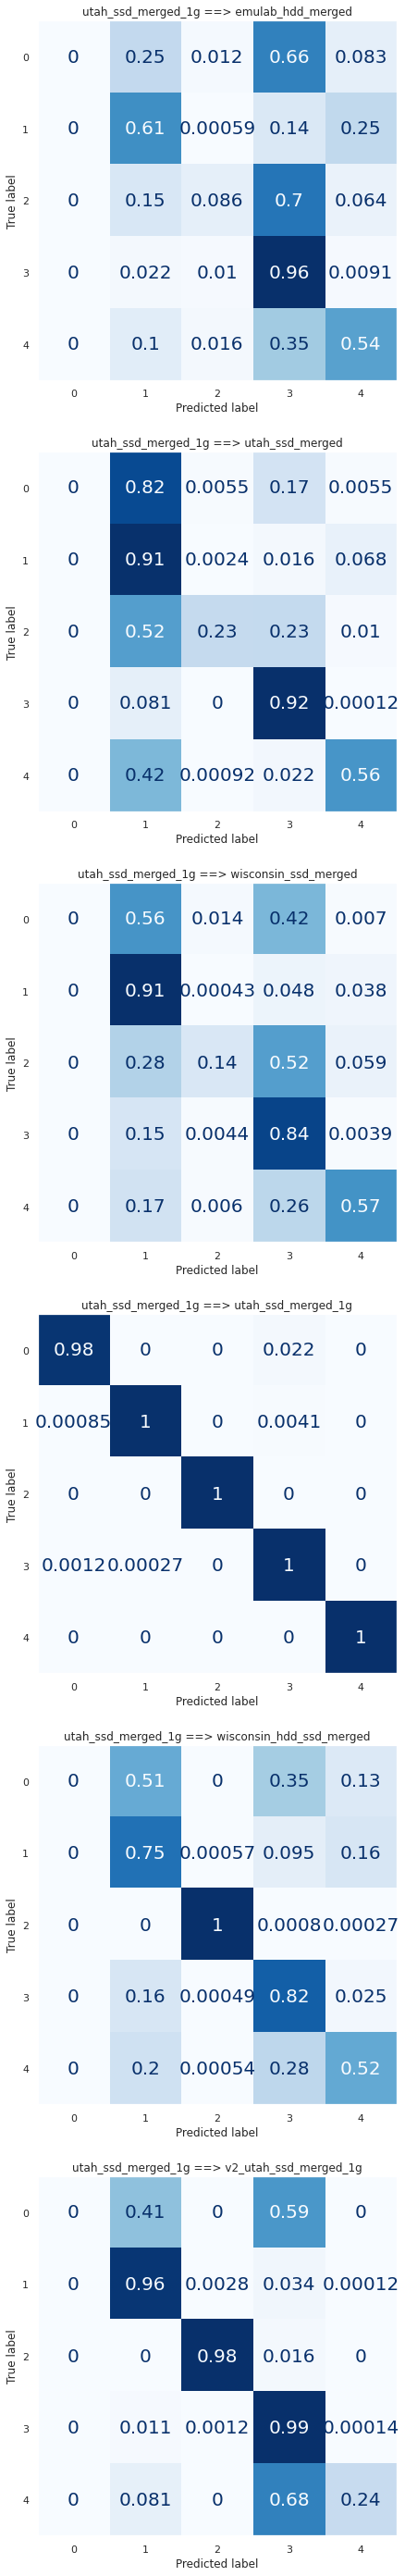

In [17]:
# creating confusion matrix for the chosen dataset and model
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
transfer_learning_acc = []
fig, axes = plt.subplots(6,1, figsize=(10, 50))
plt.rcParams.update({'font.size': 20})
# feature_list = ['sender_seg_out', 'sender_avg_send_value', 'sender_read_bytes_io', 'sender_write_bytes_io', 'sender_ost_read', 'sender_ost_write', 'sender_pending_read_pages', 'sender_read_RPCs_in_flight', 'sender_remote_ost_read_bytes', 'sender_remote_ost_write_bytes', 'receiver_segs_in', 'receiver_write_bytes_io', 'receiver_ost_write', 'receiver_remote_ost_read_bytes', 'receiver_remote_ost_write_bytes', 'sender_read_bytes', 'receiver_write_bytes']
# 19, 28, 46, 73, 82, 100
labels_values = [ 91, 100, 46, 73]# [ 91, 100, 46, 109, 113, 117, 129, 133, 157 ]#[ 91, 100, 46]# [ 91, 100, 46, 145, 151, 129, 133, 117, 113, 109, 157]# #[117, 145, 109, 129, 113, 133, 157]#[ 91, 100, 46]# [133, 145, 91, 100, 19]
key1 = "utah_ssd_merged_1g"
# key1 = "v2_utah_ssd_merged_1g"
# key1 = "wisconsin_ssd_merged"
# key1 = "utah_ssd_merged"
df = data[key1].copy()
df = remove_labels_in_df(df, labels_values)
df = normalize_df(df)
# df = grouped_to_5_cat(df,161)
df = group_to_5_cate_version2(df,161)
y = df.label_value
X = df[feature_list]#.drop(columns="label_value")#[feature_list] #.drop(columns="label_value")
X_train, X_test, y_train, y_test = train_test_split(X,y)
# X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)
X_train, y_train = RandomOverSampler(sampling_strategy="all").fit_resample(X_train, y_train)

clf = RandomForestClassifier(n_estimators=100)
# clf = tree.DecisionTreeClassifier(max_depth=9)
clf.fit(X_train, y_train)
acc = np.array([])
for index, key2 in enumerate(data):
    print(key2)
    # if key1 == key2:
    #     continueK

    df_test = data[key2].copy()
    df_test = remove_labels_in_df(df_test, labels_values)
    df_test = normalize_df(df_test)
    # df_test = grouped_to_5_cat(df_test,161)
    df_test = group_to_5_cate_version2(df_test,161)
    y_test = df_test.label_value
    X_test = df_test[feature_list]#.drop(columns="label_value")#[feature_list]#.drop(columns="label_value")#.drop(columns="label_value")

    y_pred = clf.predict(X_test)
    # y_pred_5cat = change_labels_5(y_pred, 21)
    # y_test_5cat = change_labels_5(y_test, 21)
    np.round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    print(f"{key1} ==> {key2} - {np.round(metrics.f1_score(y_test, y_pred, average='weighted') * 100, 2)}")
    acc = np.append(acc, np.round(metrics.f1_score(y_test, y_pred, average='weighted') * 100, 2))

    axes[index].grid(False)
    axes[index].set_title(f"{key1} ==> {key2}")
    # axes[index].set_xlabel('True classes', fontsize=20)
    # axes[index].set_ylabel('Predicted classes', fontsize=20)
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                                   labels=clf.classes_, normalize='true',
                                                   cmap=plt.cm.Blues, ax=axes[index], colorbar=False )
    # np.round(metrics.accuracy_score(y_test_5cat, y_pred_5cat) * 100, 2)
    # print(f"{key1} ==> {key2} - {np.round(metrics.f1_score(y_test_5cat, y_pred_5cat, average='weighted') * 100, 2)}")
    # acc = np.append(acc, np.round(metrics.f1_score(y_test_5cat, y_pred_5cat, average='weighted') * 100, 2))
transfer_learning_acc.append(acc)
print("\n")
transfer_learning_acc = np.array(transfer_learning_acc)
# fig.savefig("confusion_matrix_tb4.jpg", dpi=100, bbox_inches='tight')

## RUN with montage application

In [55]:
wisconsin_ssd_merged = pd.read_csv(filenames.get('wisconsin_ssd_merged')).drop(['time_stamp', 'through_put'], axis=1)

# montage_df = pd.read_csv("normal.csv").drop(['time_stamp', 'through_put'], axis=1)
# wisconsin_ssd_merged = wisconsin_ssd_merged.append(montage_df, ignore_index=True)

df = wisconsin_ssd_merged

y = df.label_value
X = df.drop(columns="label_value")[features] # df[features]
X_train, X_test, y_train, y_test = train_test_split(X,y)
print(X_train.shape)
# X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)
# X_train, y_train = RandomOverSampler(sampling_strategy="all").fit_resample(X_train, y_train)
# X_train, y_train = SMOTE().fit_resample(X_train, y_train) #(sampling_strategy="all").fit_resample(X_train, y_train)

print(X_train.shape)
clf = RandomForestClassifier(n_estimators=100)
# clf = make_pipeline(StandardScaler(), clf)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(np.round(metrics.accuracy_score(y_test, y_pred) * 100, 2))
# print(metrics.confusion_matrix(y_test, y_pred))

(18156, 28)
(18156, 28)
98.74


In [298]:
wisconsin_ssd_merged[['sender_ost_read','sender_remote_ost_read_bytes']]

,sender_ost_read,sender_remote_ost_read_bytes
0,9470926,532676608
1,9498585,536870912
2,9554871,541065216
3,9560776,536870912
4,9502055,536870912
...,...,...
24203,218169,33554432
24204,648334,100663296
24205,650127,100663296
24206,539851,83886080


In [12]:
normal = df.loc[df['label_value'] == 0]
y_pred = clf.predict(normal.drop(columns="label_value")[features])
# y_pred = clf.predict(normal.drop(columns="label_value"))
print(Counter(y_pred))

Counter({0: 139, 10: 3, 151: 1})


In [296]:
normal

,sender_avg_rtt_value,sender_pacing_rate,sender_cwnd_rate,sender_avg_retransmission_timeout_value,sender_byte_ack,sender_seg_out,sender_retrans,sender_ssthresh_value,sender_segs_in,sender_avg_send_value,...,receiver_setattr_md,receiver_read_page_md,receiver_unlink_md,receiver_avg_dsack_dups_value,receiver_avg_reord_seen,receiver_system_cpu_percent,receiver_system_memory_percent,receiver_remote_ost_read_bytes,receiver_remote_ost_write_bytes,label_value
9005,0.329,0.0,591.0,201.0,526.314484,381531.0,0.0,548.0,3560.0,20808.9,...,0,0,0,0.0,0.0,4.1,1.6,0,549453072,0
9006,0.486,30502.1,641.0,201.0,523.164070,379582.0,0.0,548.0,3164.0,15278.5,...,0,0,0,0.0,0.0,4.5,1.7,0,532676608,0
9007,0.263,30502.1,659.0,201.0,525.744080,380493.0,0.0,548.0,3401.0,29026.1,...,0,0,0,0.0,0.0,4.5,1.7,0,528482304,0
9008,0.319,30502.1,667.0,201.0,521.473427,378001.0,0.0,548.0,3147.0,24221.1,...,0,0,0,0.0,0.0,4.4,1.8,0,528482304,0
9009,5.324,2071.3,476.0,206.0,368.986862,267381.0,1.0,474.0,2275.0,1035.7,...,1,0,0,0.0,0.0,3.7,1.9,0,494927872,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9143,0.402,23871.2,637.0,201.0,522.140564,378315.0,0.0,478.0,3600.0,18355.7,...,0,0,0,0.0,0.0,4.5,2.4,0,465567744,0
9144,0.368,23871.2,657.0,201.0,522.481987,378360.0,0.0,478.0,3406.0,20681.2,...,0,0,0,0.0,0.0,4.5,2.4,0,478150656,0
9145,0.313,23871.2,677.0,201.0,521.331459,377743.0,0.0,478.0,3178.0,25055.5,...,0,0,0,0.0,0.0,4.0,2.5,0,419430400,0
9146,0.271,23871.2,691.0,201.0,448.237671,324729.0,0.0,478.0,2943.0,29537.1,...,1,0,0,0.0,0.0,3.9,2.5,0,411041792,0


In [13]:
# montage_df = pd.read_csv("normal.csv").drop(['time_stamp', 'through_put'], axis=1)
montage_df = pd.read_csv("./montage_analysis/long_montage_5_instance.csv").drop(['time_stamp'], axis=1)
print(montage_df.shape)
# montage_df = montage_df.iloc[49:56]
# montage_df['sender_remote_ost_write_bytes']
montage_df_write_part = montage_df.loc[(montage_df['sender_remote_ost_write_bytes'] > 0)]
montage_df_write_part
montage_df

(239, 118)


,sender_avg_rtt_value,sender_pacing_rate,sender_cwnd_rate,sender_avg_retransmission_timeout_value,sender_byte_ack,sender_seg_out,sender_retrans,sender_ssthresh_value,sender_segs_in,sender_avg_send_value,...,receiver_read_page_md,receiver_unlink_md,receiver_avg_dsack_dups_value,receiver_avg_reord_seen,receiver_system_cpu_percent,receiver_system_memory_percent,receiver_remote_ost_read_bytes,receiver_remote_ost_write_bytes,through_put,label_value
0,0.252,32161.8,350.0,201.0,528.000000,382595.0,0.0,102.0,3711.0,16088.9,...,0,0,0.0,0.0,4.0,1.8,0,494927872,3.072611,1002
1,0.504,21145.4,460.0,201.0,507.576744,368094.0,0.0,102.0,3301.0,10572.7,...,0,0,0.0,0.0,4.3,1.9,0,473956352,2.898157,1002
2,0.249,21145.4,533.0,201.0,345.753250,250423.0,0.0,102.0,1900.0,24796.3,...,0,0,0.0,0.0,3.6,1.9,0,473956352,3.193359,1002
3,0.248,21145.4,587.0,201.0,534.670006,387491.0,0.0,102.0,3502.0,27418.6,...,0,0,0.0,0.0,4.2,1.9,0,457179136,3.771484,1002
4,0.294,21145.4,621.0,201.0,526.802261,381665.0,0.0,102.0,3102.0,24468.2,...,0,0,0.0,0.0,4.1,2.0,0,465567744,3.746514,1002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,0.327,20618.5,557.0,201.0,451.581688,327366.0,0.0,446.0,3614.0,19731.8,...,0,0,0.0,0.0,3.8,8.1,0,469762048,3.182617,1002
235,0.623,20701.1,557.0,201.0,424.398834,307689.0,0.0,446.0,3392.0,10356.8,...,0,0,0.0,0.0,3.6,8.1,0,452984832,3.068359,1002
236,0.340,20701.1,557.0,201.0,443.343933,321328.0,0.0,446.0,3541.0,18977.3,...,0,0,0.0,0.0,5.5,7.9,0,469762048,3.180664,1002
237,0.349,20701.1,579.0,201.0,428.133873,310432.0,0.0,446.0,3378.0,19218.2,...,0,0,0.0,0.0,7.0,7.7,0,457179136,3.095703,1002


In [14]:
montage_df_write_part

,sender_avg_rtt_value,sender_pacing_rate,sender_cwnd_rate,sender_avg_retransmission_timeout_value,sender_byte_ack,sender_seg_out,sender_retrans,sender_ssthresh_value,sender_segs_in,sender_avg_send_value,...,receiver_read_page_md,receiver_unlink_md,receiver_avg_dsack_dups_value,receiver_avg_reord_seen,receiver_system_cpu_percent,receiver_system_memory_percent,receiver_remote_ost_read_bytes,receiver_remote_ost_write_bytes,through_put,label_value
1,0.504,21145.4,460.0,201.0,507.576744,368094.0,0.0,102.0,3301.0,10572.7,...,0,0,0.0,0.0,4.3,1.9,0,473956352,2.898157,1002
2,0.249,21145.4,533.0,201.0,345.753250,250423.0,0.0,102.0,1900.0,24796.3,...,0,0,0.0,0.0,3.6,1.9,0,473956352,3.193359,1002
10,0.324,33820.4,580.0,201.0,504.291557,365446.0,11.0,474.0,3070.0,20736.8,...,0,0,0.0,0.0,4.0,2.3,0,385875968,3.682272,1002
12,0.457,33109.8,654.0,201.0,513.027443,371726.0,0.0,474.0,2774.0,16577.5,...,0,0,0.0,0.0,3.9,2.5,0,402653184,3.746094,1002
27,0.372,28448.7,666.0,201.0,328.228477,237553.0,0.0,474.0,2614.0,20739.1,...,0,0,0.0,0.0,2.9,3.0,0,343932928,2.343750,1002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,0.440,33999.9,647.0,201.0,288.855759,209311.0,0.0,358.0,1435.0,17033.7,...,0,0,0.0,0.0,7.6,7.1,0,448790528,2.832290,1002
161,0.660,25039.9,714.0,201.0,472.824814,342558.0,0.0,358.0,2160.0,12531.8,...,0,0,0.0,0.0,6.8,6.6,0,452984832,3.188827,1002
162,0.412,25039.9,720.0,201.0,472.000000,342030.0,0.0,358.0,2095.0,20243.9,...,0,0,0.0,0.0,3.8,6.6,0,469762048,3.478516,1002
177,0.322,29679.9,885.0,201.0,348.650642,252617.0,0.0,358.0,2790.0,31838.0,...,0,0,0.0,0.0,2.9,7.4,0,369098752,2.490234,1002


In [56]:
montage_X = montage_df_write_part.drop(columns="label_value")[features]
# montage_X = montage_df.drop(columns="label_value")[features]
# y_pred = clf.predict(normal.drop(columns="label_value"))
y_pred = clf.predict(montage_X)
print(Counter(y_pred))
len(y_pred)
# print(30/102)

Counter({64: 108, 82: 3, 55: 3})


114

In [17]:
y_pred == 64

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True])

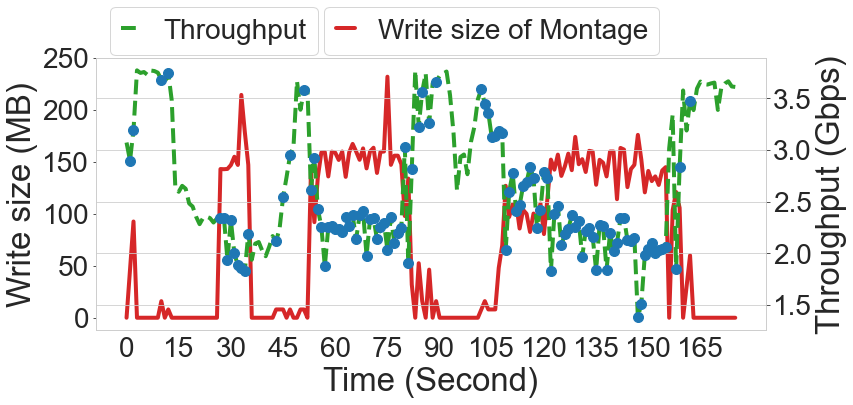

In [114]:
montage_1_df = pd.read_csv("./montage_analysis/montage_1_instance.csv")
montage_5_df = pd.read_csv("./montage_analysis/long_montage_5_instance.csv")
normal_df = pd.read_csv("./montage_analysis/normal.csv")
rows = montage_df.shape[0]

from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
# plt.rcParams.update({'font.size': 15})
sns.set_style("whitegrid")
sns.set_palette("Set1")

fig, ax = plt.subplots(figsize =(12, 5))
x_range = np.arange(0, 176 , 1)
lw=4
# markersize=10

ax.set_ylabel('Write size (MB)', fontsize=33)
ax.plot(x_range, montage_5_df.iloc[:176,:]['sender_remote_ost_write_bytes']/(1024 * 1024),'-', label="Write size of Montage",color='tab:red', linewidth=lw)
ax.set_xlabel('Time (Second)', fontsize=33)

plt.yticks(np.arange(0, np.max(montage_5_df.iloc[:176,:]['sender_remote_ost_write_bytes']/(1024 * 1024)) + 50, 50),  fontsize=28)
plt.xticks(np.arange(0, 176 , 15),  fontsize=28)

plt.legend(fontsize=28, framealpha=0.8, handlelength=0.7, loc='upper left', bbox_to_anchor=(0.32, 1.24))
# fig.suptitle('Monitoring agent\'s Resource Usage footprints')

real_writes_x = montage_5_df.loc[(montage_5_df['sender_remote_ost_write_bytes'] > 0)].index
real_writes_y = montage_5_df.loc[(montage_5_df['sender_remote_ost_write_bytes'] > 0)]
# ax.plot(real_writes_x, real_writes_y['through_put'], 'ro',label="While Montage is writing")
ax.grid(False)

ax2 = ax.twinx()
# ax2.set_xticks(np.arange(0, 176 , 15),  fontsize=28)

# ax2.set_yticks(np.arange(0, 4.5, 0.5),  fontsize=28)
plt.yticks(np.arange(0, 4.5, 0.5),  fontsize=28)
ax2.set_ylabel('Throughput (Gbps)', fontsize=33)
# ax2.grid(True,which='both', axis='y', linestyle='--', alpha=0.5)


# ax2.plot(np.arange(0, normal_df.shape[0]  , 1), montage_df.iloc[:normal_df.shape[0],:]['through_put'])
# ax2.plot(np.arange(0, 75  , 1), montage_1_df.iloc[:75]['through_put'], 'x')
# ax2.plot(x_range, normal_df['through_put'], 'mx', label="Normal")
line1, = ax2.plot(x_range, montage_5_df.iloc[:176,:]['through_put'], '--', label="Throughput", color='tab:green', linewidth=lw)
plt.legend(fontsize=28, handles=[line1], handlelength=0.7,  framealpha=0.8, loc='upper left', bbox_to_anchor=(0.0, 1.24))

ax2.plot(real_writes_x[(y_pred == 64)], real_writes_y.iloc[(y_pred == 64)]['through_put'], ls="", marker="o", markersize=10,label="Recognized by model" , color='tab:blue')

# plt.axvline(x=26,linestyle='--', alpha=0.7, color='red') (0.33,0.65,0.41)
# plt.axvline(x=36,linestyle='--', alpha=0.7, color='red')

# plt.axvline(x=52,linestyle='--', alpha=0.7, color='red')
# plt.axvline(x=82,linestyle='--', alpha=0.7, color='red')

# plt.axvline(x=108,linestyle='--', alpha=0.7, color='red')
# plt.axvline(x=158,linestyle='--', alpha=0.7, color='red')

# ax2.grid(True,which='both', axis='y', linestyle='-.', alpha=0.5)

# ax.xaxis.grid()
# ax.grid(axis='x',linestyle='--')
plt.savefig("Real_world_montage.pdf", bbox_inches='tight')


In [257]:
montage_X = montage_df.drop(columns="label_value")[features]
# y_pred = clf.predict(normal.drop(columns="label_value"))
y_pred = clf.predict(montage_X)
# print(Counter(y_pred[:176]))
print(Counter(y_pred))
len(y_pred)
#Counter({64: 114, 73: 47, 82: 44, 46: 22, 91: 12})
#Counter({64: 113, 73: 58, 82: 31, 46: 27, 91: 10})

#Counter({64: 114, 73: 52, 82: 39, 46: 20, 91: 14})

Counter({64: 113, 73: 52, 82: 39, 46: 27, 91: 8})


239

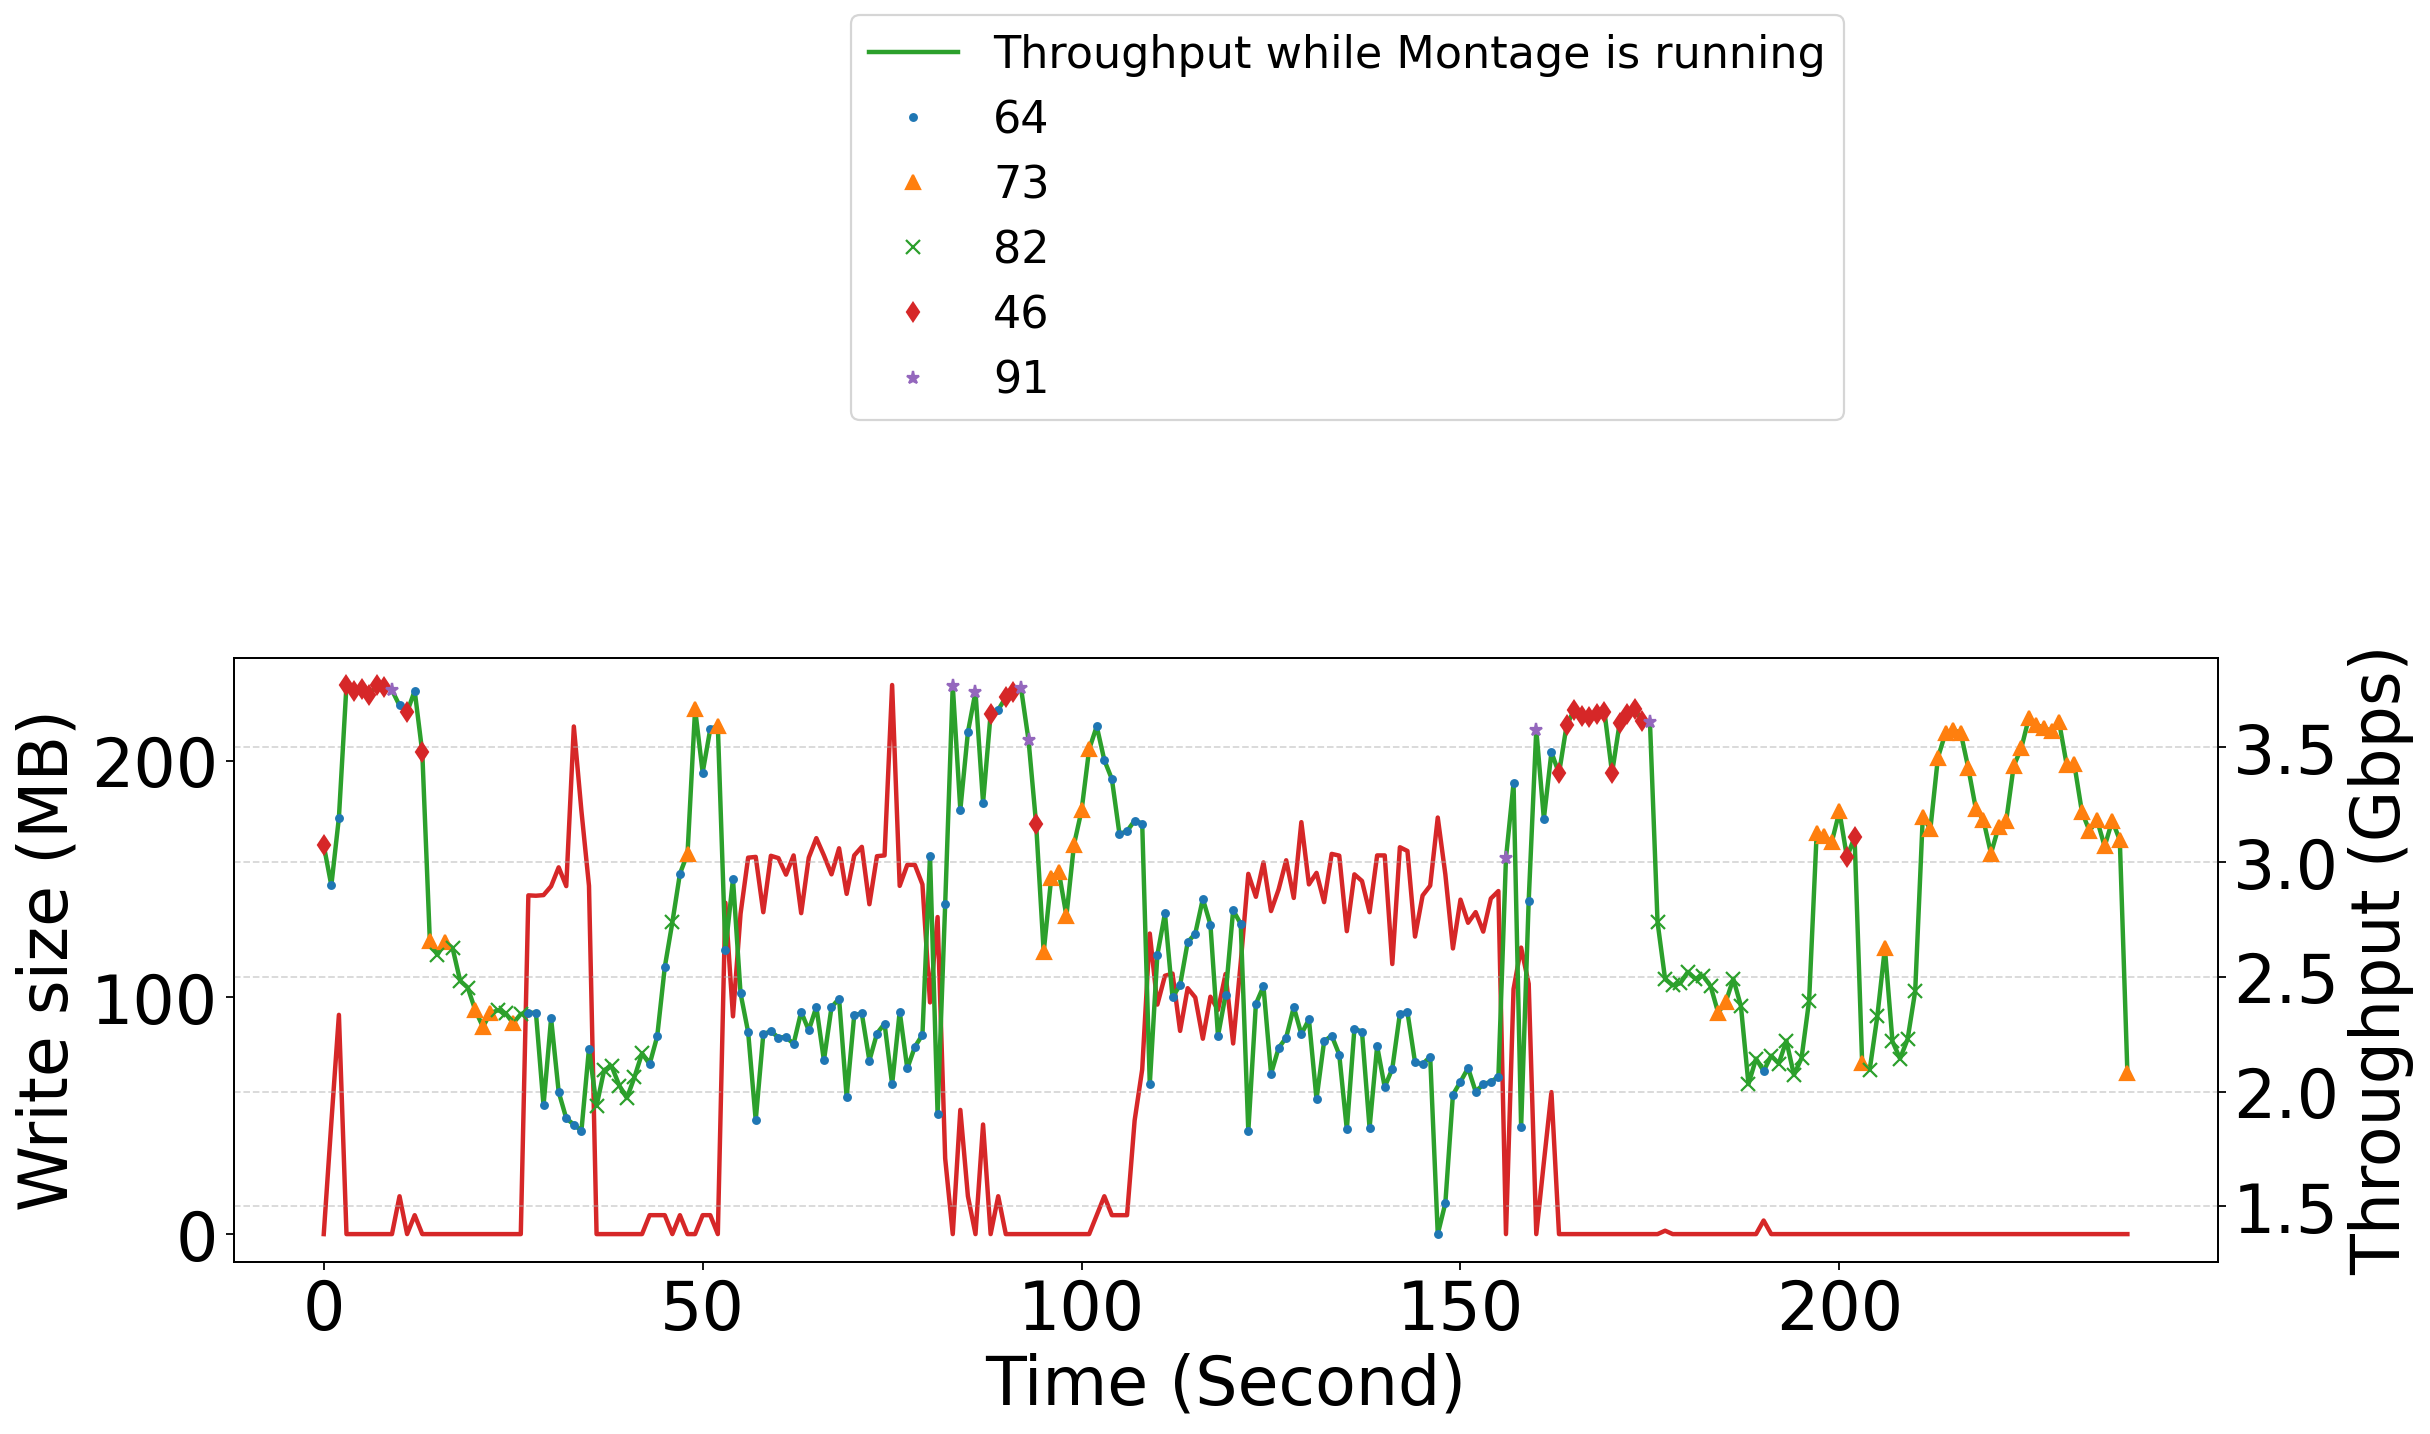

In [264]:

montage_5_df = montage_df.copy()
rows = montage_df.shape[0]

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 30})

fig, ax = plt.subplots(figsize =(16, 5), dpi=160)
x_range = np.arange(0, 239 , 1)

ax.set_ylabel('Write size (MB)')
ax.plot(x_range, montage_5_df['sender_remote_ost_write_bytes']/(1024 * 1024),'-', label="Write size of Montage",color='tab:red', linewidth=2)
ax.set_xlabel('Time (Second)')

# fig.suptitle('Monitoring agent\'s Resource Usage footprints')

# print(real_writes_x)
ax2 = ax.twinx()
ax2.set_xticks(np.arange(0, 239 , 50))
ax2.set_yticks(np.arange(0, 4.5, 0.5))
ax2.set_ylabel('Throughput (Gbps)')
ax2.grid(True,which='both', axis='y', linestyle='--', alpha=0.5)


line1, = ax2.plot(x_range, montage_5_df.iloc[:239,:]['through_put'], '-', label="Throughput while Montage is running", color='tab:green', linewidth=2)
plt.legend(fontsize=10, handles=[line1], framealpha=0.8, loc='upper left', bbox_to_anchor=(0, 1.2))

#{64: 98, 82: 75, 46: 45, 10: 9, 0: 8, 91: 2, 73: 2}
# x_64 = montage_5_df.loc[y_pred==64].index
# y_64 = montage_5_df.loc[y_pred == 64]
# print(x_64)
#Counter({64: 114, 73: 52, 82: 39, 46: 20, 91: 14})

ax2.plot(montage_5_df.loc[y_pred==64].index,  montage_5_df.loc[y_pred == 64]['through_put'],'.',linewidth=1, label="64")
ax2.plot(montage_5_df.loc[y_pred==73].index,  montage_5_df.loc[y_pred == 73]['through_put'],'^',linewidth=1, label="73")
ax2.plot(montage_5_df.loc[y_pred==82].index,  montage_5_df.loc[y_pred == 82]['through_put'],'x',linewidth=1, label="82")
ax2.plot(montage_5_df.loc[y_pred==46].index,  montage_5_df.loc[y_pred == 46]['through_put'],'d',linewidth=1, label="46")
# ax2.plot(montage_5_df.loc[y_pred==0].index,  montage_5_df.loc[y_pred == 0]['through_put'],'+',linewidth=1, label="0")
ax2.plot(montage_5_df.loc[y_pred==91].index,  montage_5_df.loc[y_pred == 91]['through_put'],'*',linewidth=1, label="91")
# ax2.plot(montage_5_df.loc[y_pred==73].index,  montage_5_df.loc[y_pred == 73]['through_put'],'v',linewidth=1, label="73")


plt.legend(fontsize=20, framealpha=0.8, loc='upper left', bbox_to_anchor=(0.3, 2.1))
# plt.axvline(x=26,linestyle='--', alpha=0.7, color='red') (0.33,0.65,0.41)
# plt.axvline(x=36,linestyle='--', alpha=0.7, color='red')

# plt.axvline(x=52,linestyle='--', alpha=0.7, color='red')
# plt.axvline(x=82,linestyle='--', alpha=0.7, color='red')

# plt.axvline(x=108,linestyle='--', alpha=0.7, color='red')
# plt.axvline(x=158,linestyle='--', alpha=0.7, color='red')

# ax2.grid(True,which='both', axis='y', linestyle='-.', alpha=0.5)

# ax.xaxis.grid()
# ax.grid(axis='x',linestyle='--')


# REAL_WORLD APPLICATION on Utah cluster

In [242]:
utah_ssd_merged = pd.read_csv(filenames.get('utah_ssd_merged')).drop(['time_stamp', 'through_put'], axis=1)

# montage_df = pd.read_csv("normal.csv").drop(['time_stamp', 'through_put'], axis=1)
# wisconsin_ssd_merged = wisconsin_ssd_merged.append(montage_df, ignore_index=True)

df = utah_ssd_merged

y = df.label_value
X = df.drop(columns="label_value")[features] # df[features]
X_train, X_test, y_train, y_test = train_test_split(X,y)
print(X_train.shape)
X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)
print(X_train.shape)
clf = RandomForestClassifier(n_estimators=100)
# clf = make_pipeline(StandardScaler(), clf)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(np.round(metrics.accuracy_score(y_test, y_pred) * 100, 2))

(22613, 24)
(2772, 24)
99.19


In [235]:
normal = df.loc[df['label_value'] == 0]
y_pred = clf.predict(normal.drop(columns="label_value")[features])
# y_pred = clf.predict(normal.drop(columns="label_value"))
print(Counter(y_pred))

Counter({0: 181})


In [236]:
# montage_df = pd.read_csv("normal.csv").drop(['time_stamp', 'through_put'], axis=1)
montage_df = pd.read_csv("./montage_analysis/utah_montage_5_instance.csv").drop(['time_stamp','through_put'], axis=1)
# print(montage_df.shape)
# montage_df = montage_df.iloc[49:56]
# montage_df['sender_remote_ost_write_bytes']
montage_df_write_part = montage_df.loc[(montage_df['sender_remote_ost_write_bytes'] > 0)]
montage_df_write_part
# montage_df

,sender_avg_rtt_value,sender_pacing_rate,sender_cwnd_rate,sender_avg_retransmission_timeout_value,sender_byte_ack,sender_seg_out,sender_retrans,sender_ssthresh_value,sender_segs_in,sender_avg_send_value,...,receiver_setattr_md,receiver_read_page_md,receiver_unlink_md,receiver_avg_dsack_dups_value,receiver_avg_reord_seen,receiver_system_cpu_percent,receiver_system_memory_percent,receiver_remote_ost_read_bytes,receiver_remote_ost_write_bytes,label_value
3,0.185,15651.3,938.0,201.0,511.540741,370950.0,0.0,20.0,2141.0,58734.0,...,0,0,0,0.0,0.0,2.6,3.0,0,503316480,1002
7,0.399,15651.3,1195.0,201.0,516.000000,374027.0,0.0,20.0,1576.0,34693.9,...,0,0,0,0.0,0.0,2.5,3.2,0,494927872,1002
9,0.364,15651.3,939.0,201.0,521.301918,377612.0,0.0,846.0,1530.0,29882.9,...,0,0,0,0.0,0.0,2.6,3.3,0,511705088,1002
18,0.209,926.9,836.0,201.0,504.194321,365424.0,0.0,786.0,1807.0,46336.0,...,0,0,0,0.0,0.0,2.4,3.8,0,528478656,1002
19,0.367,926.9,896.0,201.0,521.825790,378521.0,0.0,786.0,1656.0,28281.4,...,0,0,0,0.0,0.0,2.5,3.8,0,511705088,1002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0.292,1237.0,851.0,201.0,542.212105,392310.0,0.0,718.0,1514.0,33760.2,...,0,0,0,0.0,0.0,2.6,8.7,0,545259520,1002
127,0.213,1237.0,890.0,201.0,344.000000,249288.0,0.0,718.0,1473.0,48402.6,...,0,0,0,0.0,0.0,2.0,8.8,0,440401920,1002
128,0.378,1237.0,940.0,201.0,400.000000,289946.0,0.0,718.0,1481.0,28806.8,...,0,0,0,0.0,0.0,1.8,8.8,0,364904448,1002
131,0.385,1237.0,1138.0,201.0,520.000000,376845.0,0.0,718.0,1289.0,34240.5,...,0,0,0,0.0,0.0,2.6,9.0,0,503316480,1002


In [243]:
montage_X = montage_df_write_part.drop(columns="label_value")[features]
# y_pred = clf.predict(normal.drop(columns="label_value"))
y_pred = clf.predict(montage_X)
print(Counter(y_pred))
# len(y_pred)
# print(30/102)

Counter({64: 48, 157: 31, 10: 3, 0: 2})


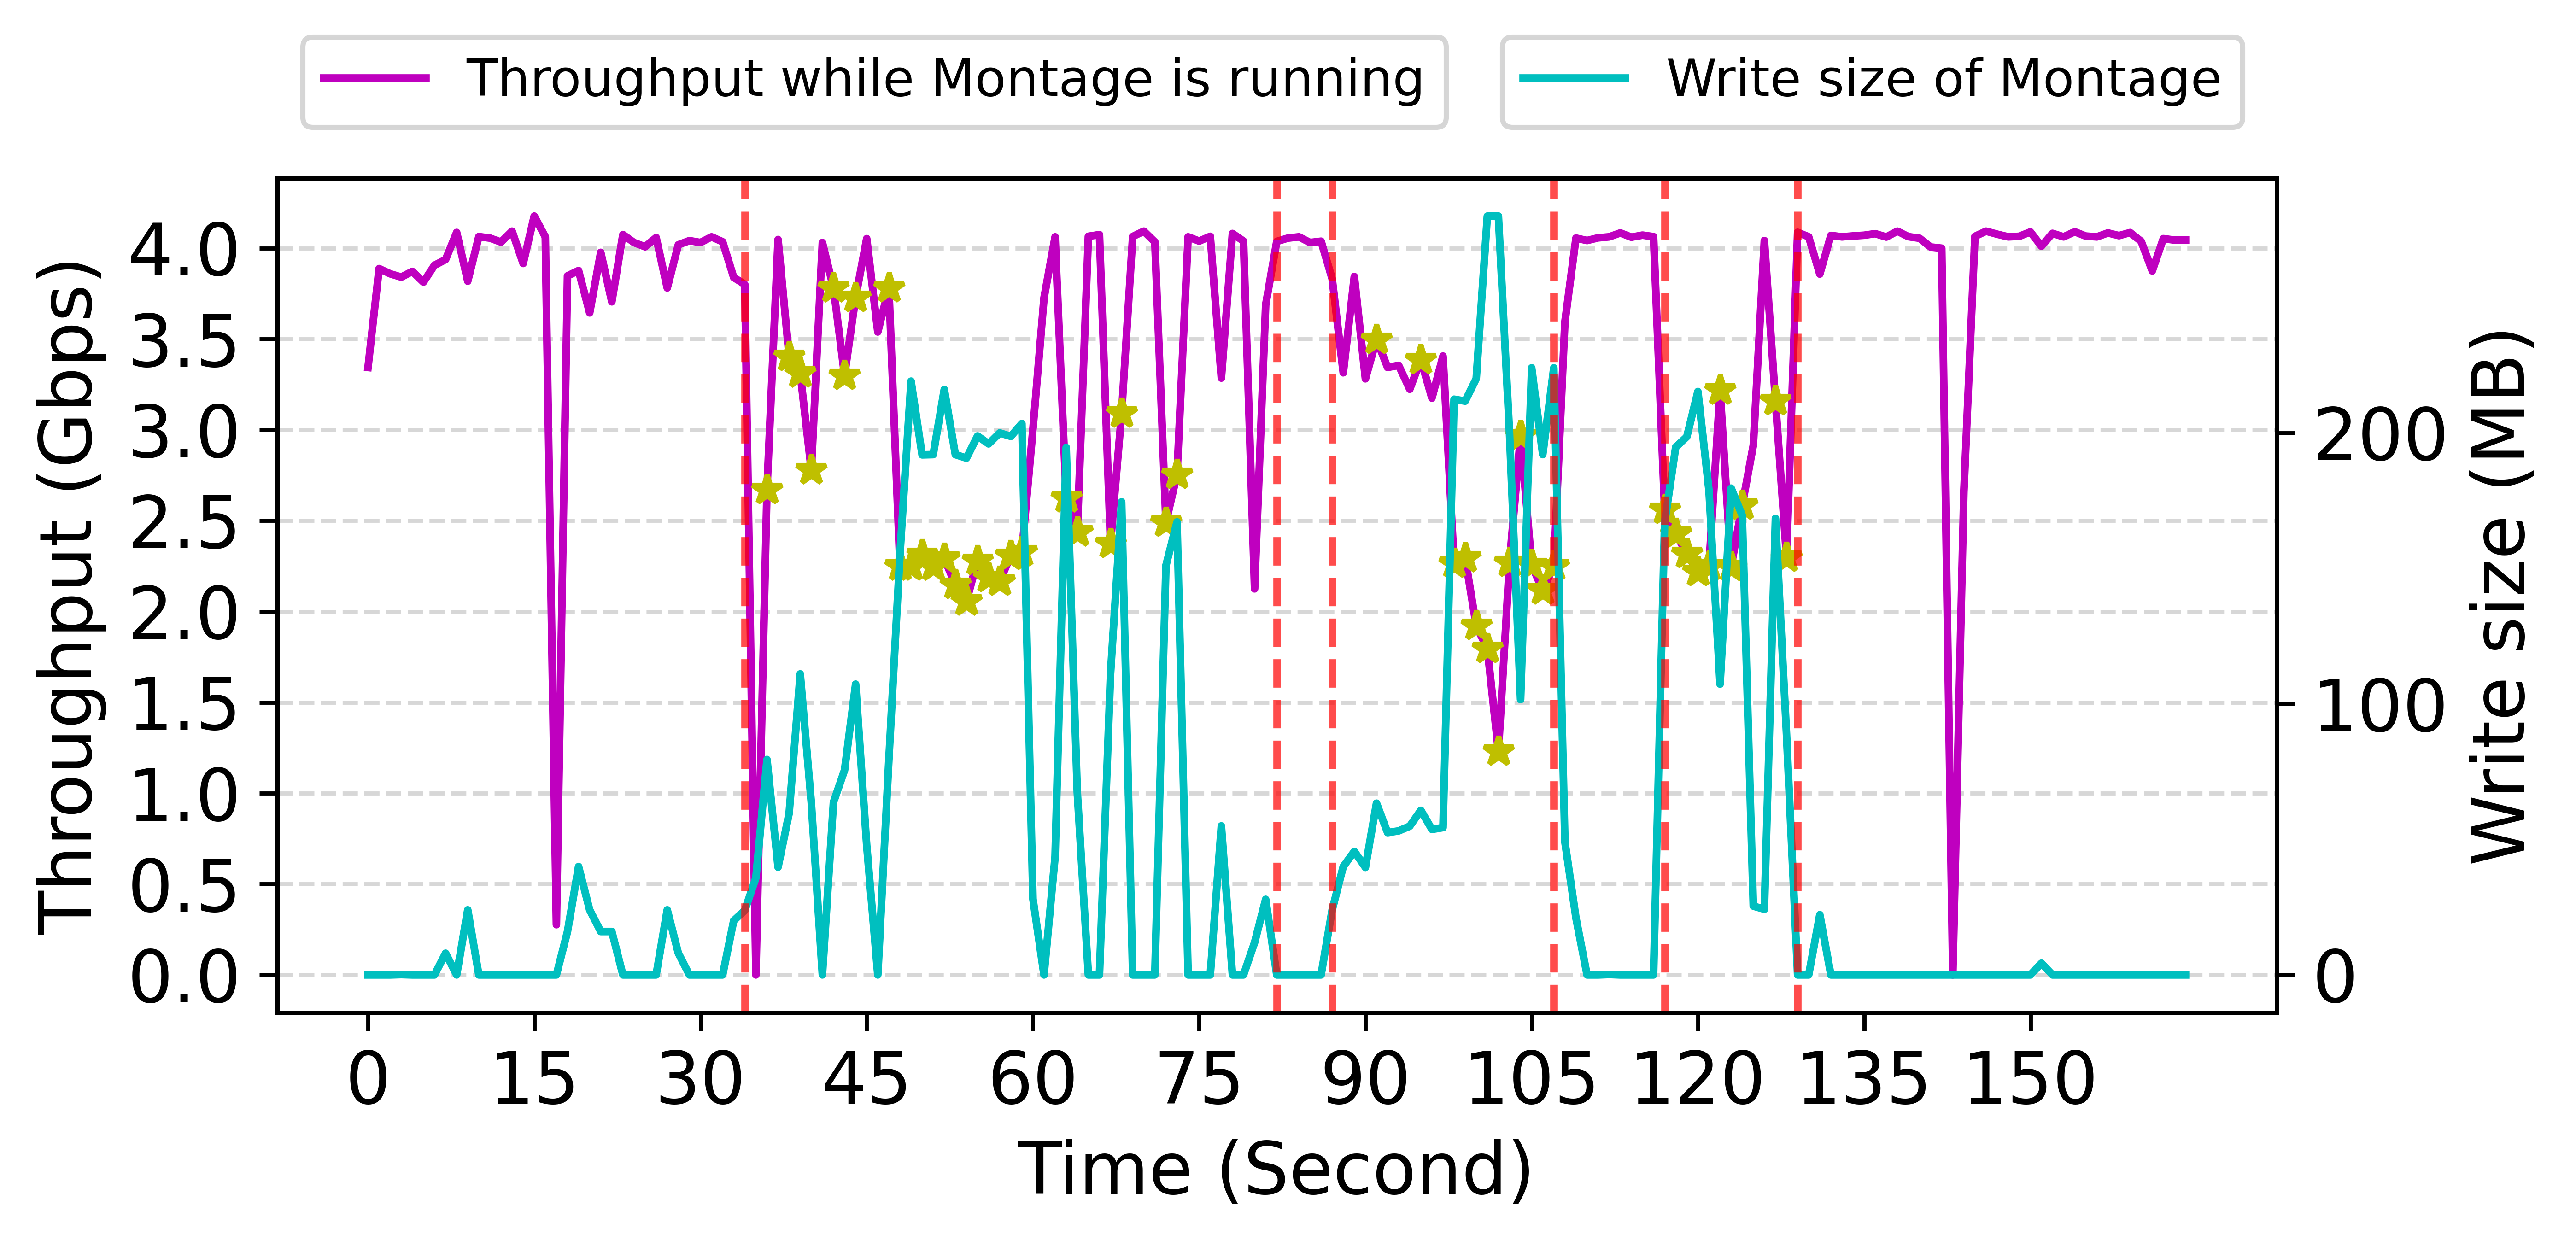

In [246]:
montage_5_df = pd.read_csv("./montage_analysis/utah_montage_5_instance.csv")
# rows = 210
rows = 165

from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize =(7, 3), dpi=800)
# fig.suptitle('Monitoring agent\'s Resource Usage footprints')
ax.set_xticks(np.arange(0, rows , 15))
ax.set_yticks(np.arange(0, 4.5, 0.5))
ax.set_ylabel('Throughput (Gbps)')
ax.set_xlabel('Time (Second)')
ax.grid(True,which='both', axis='y', linestyle='--', alpha=0.5)
x_range = np.arange(0, rows , 1)

# ax.plot(np.arange(0, normal_df.shape[0]  , 1), montage_df.iloc[:normal_df.shape[0],:]['through_put'])
# ax.plot(np.arange(0, 75  , 1), montage_1_df.iloc[:75]['through_put'], 'x')
# ax.plot(x_range, normal_df['through_put'], 'mx', label="Normal")
line1, = ax.plot(x_range, montage_5_df.iloc[:rows,:]['through_put'], 'm-', label="Throughput while Montage is running")
real_writes_x = montage_5_df.loc[(montage_5_df['sender_remote_ost_write_bytes'] > 0)].index
real_writes_y = montage_5_df.loc[(montage_5_df['sender_remote_ost_write_bytes'] > 0)]
# ax.plot(real_writes_x, real_writes_y['through_put'], 'ro',label="While Montage is writing")

ax.plot(real_writes_x[y_pred == 64], real_writes_y.iloc[y_pred == 64]['through_put'], 'y*',linewidth=0.5, label="Recognized by model" )

plt.legend(handles=[line1], framealpha=0.8, loc='upper left', prop={"size":10}, bbox_to_anchor=(0, 1.2))


ax2 = ax.twinx()
ax2.set_ylabel('Write size (MB)')
ax2.plot(x_range, montage_5_df.iloc[:rows,:]['sender_remote_ost_write_bytes']/(1024 * 1024),'c-' , label="Write size of Montage")
plt.axvline(x=34,linestyle='--', alpha=0.7, color='red')
plt.axvline(x=82,linestyle='--', alpha=0.7, color='red')
#
plt.axvline(x=87,linestyle='--', alpha=0.7, color='red')
plt.axvline(x=107,linestyle='--', alpha=0.7, color='red')
#
plt.axvline(x=117,linestyle='--', alpha=0.7, color='red')
plt.axvline(x=129,linestyle='--', alpha=0.7, color='red')

# ax2.grid(True,which='both', axis='y', linestyle='-.', alpha=0.5)
plt.legend(framealpha=0.8, loc='upper left', prop={"size":10}, bbox_to_anchor=(0.6, 1.2))
# ax.xaxis.grid()
# ax.grid(axis='x',linestyle='--')
# plt.savefig("utah_Real_world_montage.pdf", bbox_inches='tight')

In [287]:
datasets = ['emulab_hdd_merged', 'utah_ssd_merged', 'wisconsin_ssd_merged', 'utah_ssd_merged_1g', 'wisconsin_hdd_ssd_merged']
all_accuracies = {}
for key in datasets:
    df = pd.read_csv(filenames.get(key)).drop(['time_stamp', 'through_put'], axis=1)
    accuracies = []
    for n in range(5,70,5):
        train = df.groupby("label_value").sample(n)
        test = df.drop(train.index)
        y_train = train.label_value
        X_train = train[features]
        y_test = test.label_value
        X_test = test[features]
        clf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100))
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = np.round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
        accuracies.append(acc)
        # print()
        # print(f"{key},{n},{np.round(metrics.f1_score(y_test, y_pred, average='weighted') * 100, 2)}")
        # print(f"{key},{n},{acc}")
    all_accuracies[key] = accuracies
print(all_accuracies)

{'emulab_hdd_merged': [77.08, 85.49, 85.58, 87.87, 88.26, 88.69, 89.81, 89.78, 90.57, 92.35, 92.38, 91.85, 92.85], 'utah_ssd_merged': [88.58, 92.82, 95.34, 96.29, 96.77, 97.64, 97.15, 97.68, 96.45, 97.73, 97.75, 97.44, 98.29], 'wisconsin_ssd_merged': [86.67, 91.13, 93.14, 94.63, 95.09, 95.2, 95.56, 96.19, 96.36, 96.05, 96.48, 96.72, 96.43], 'utah_ssd_merged_1g': [90.94, 97.14, 97.03, 97.81, 97.94, 98.61, 98.09, 98.57, 99.08, 98.93, 98.98, 98.59, 99.09], 'wisconsin_hdd_ssd_merged': [85.34, 90.62, 93.13, 94.45, 94.14, 95.39, 95.25, 95.68, 96.59, 96.68, 95.95, 96.59, 97.17]}


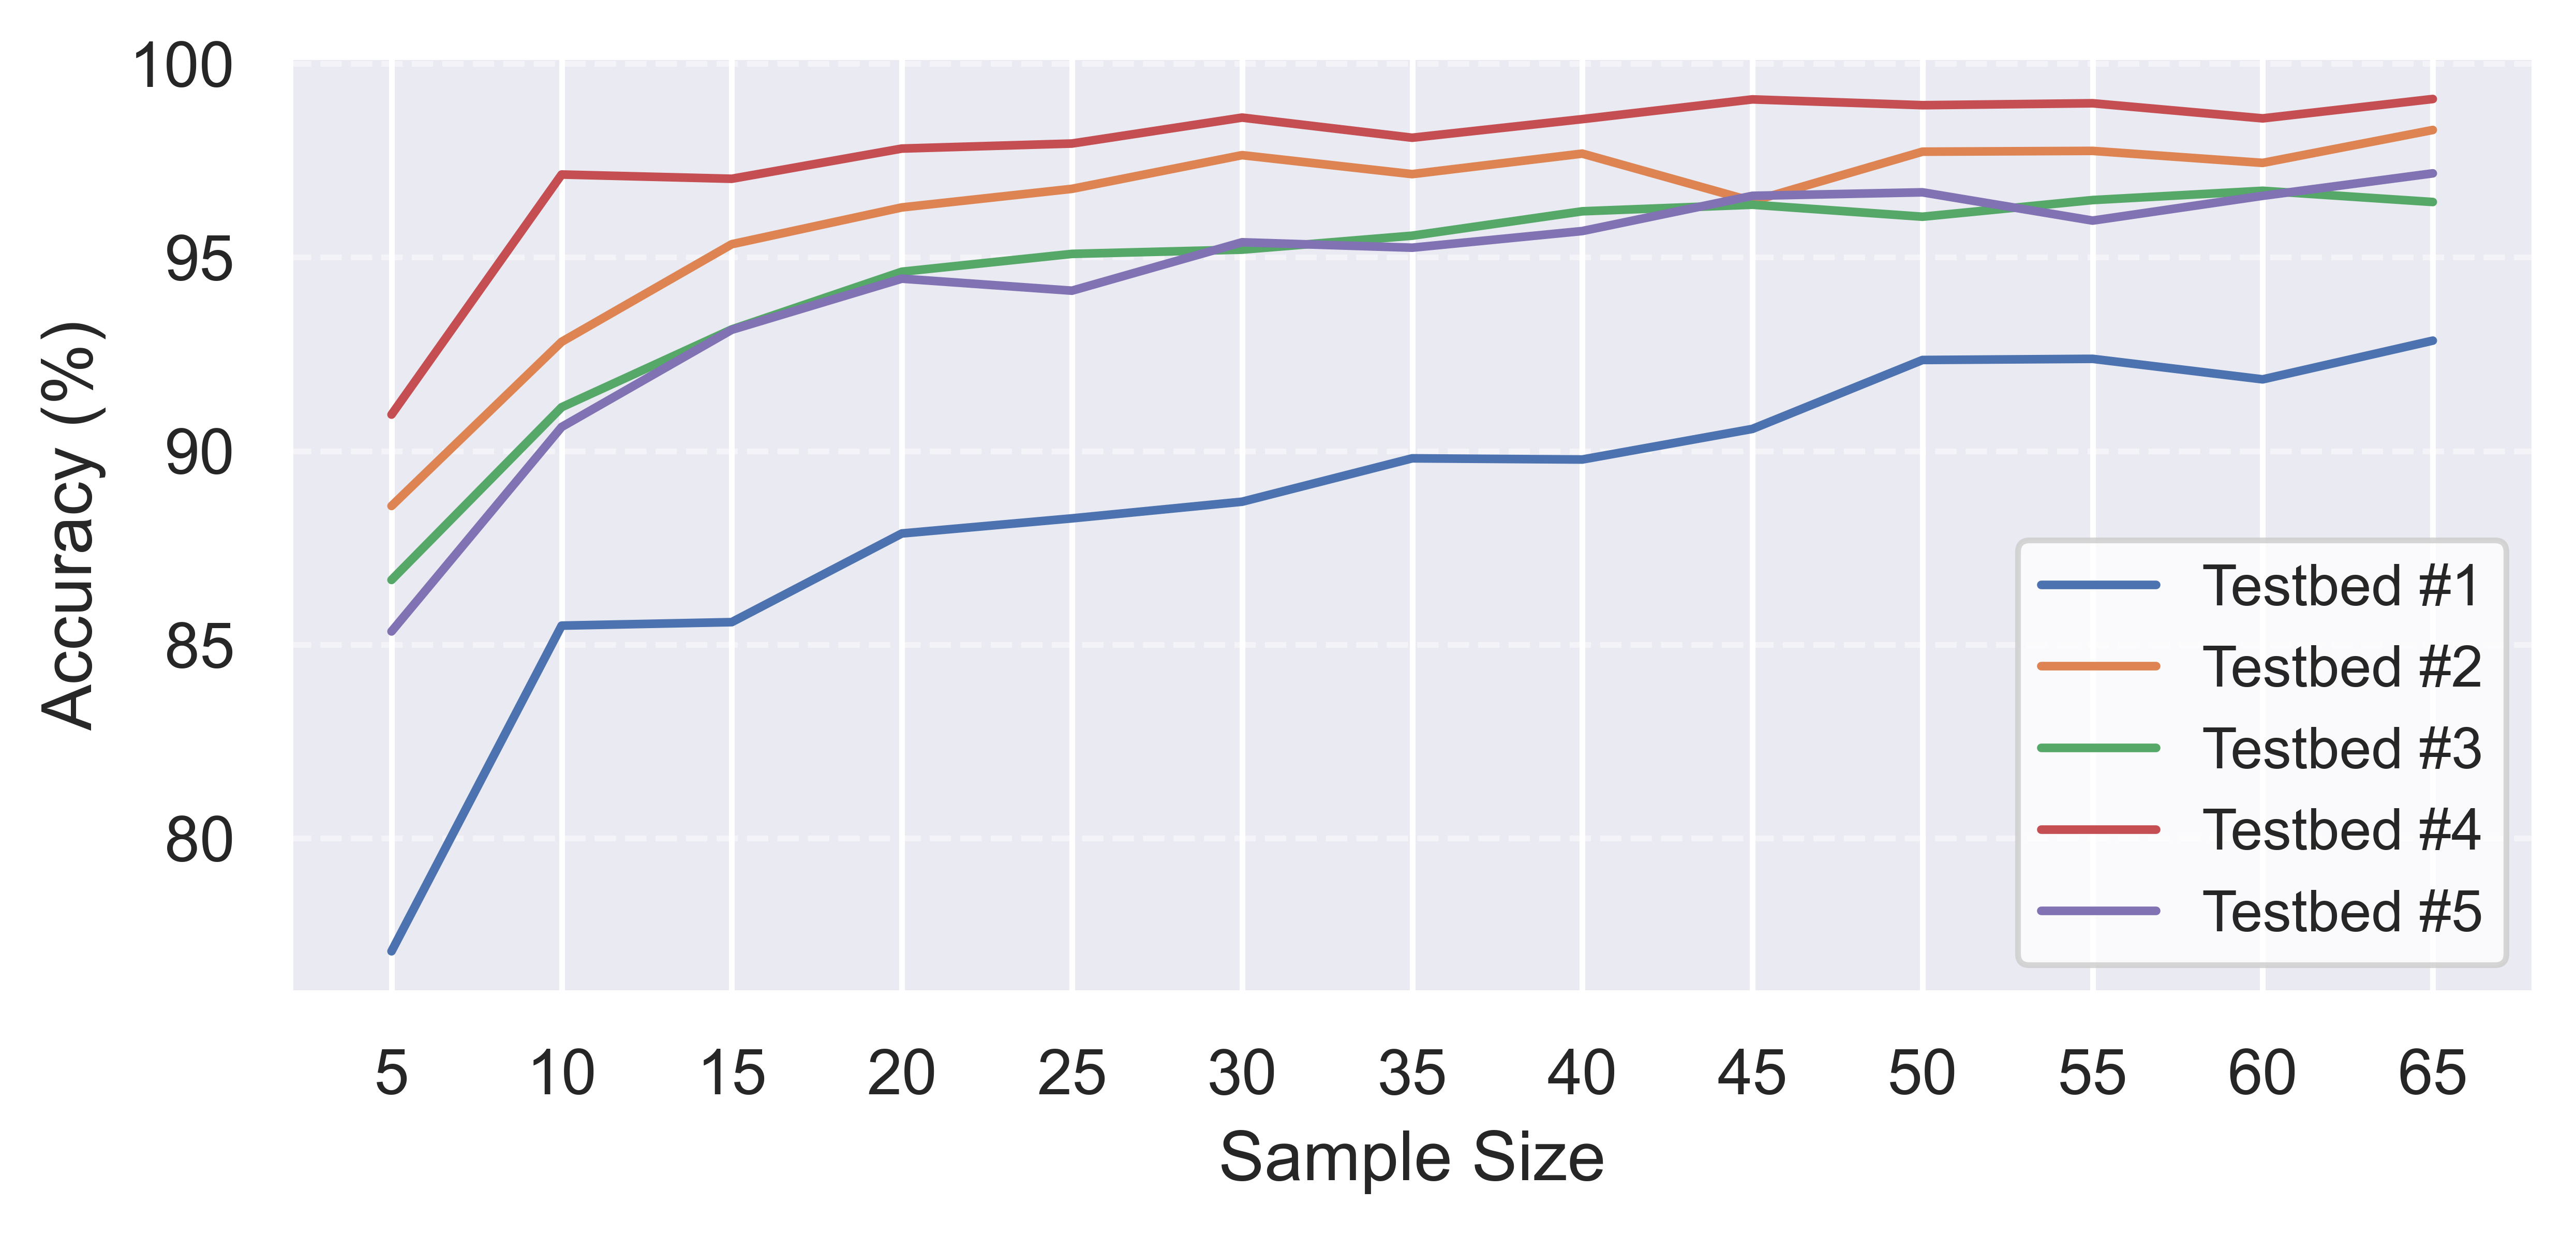

In [289]:
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})
labels = {'emulab_hdd_merged': 'Testbed #1', 'utah_ssd_merged':'Testbed #2',
          'wisconsin_ssd_merged':'Testbed #3', 'utah_ssd_merged_1g':'Testbed #4',
          'wisconsin_hdd_ssd_merged':'Testbed #5'}
fig, ax = plt.subplots(figsize =(7, 3), dpi=800)
sns.set_style("whitegrid")
sns.set_palette("Set1")
# fig.suptitle('Monitoring agent\'s Resource Usage footprints')
ax.set_xticks(np.arange(0, 69 , 5))
ax.set_yticks(np.arange(65, 105, 5))
ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Sample Size')
ax.grid(True,which='both', axis='y', linestyle='--', alpha=0.5)
x_range = np.arange(5, 70 , 5)

for ds in all_accuracies.keys():
    ax.plot(x_range, all_accuracies[ds], label=labels[ds])
plt.legend(framealpha=0.8, loc='lower right', prop={"size":10})


##

In [252]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
# ['sender_avg_rtt_value', 'sender_cwnd_rate', 'sender_seg_out', 'sender_ssthresh_value', 'sender_segs_in', 'sender_avg_send_value', 'sender_vsize', 'sender_rss', 'sender_mem_usage_percentage', 'sender_avg_waittime_md', 'sender_system_cpu_percent', 'receiver_seg_out', 'receiver_segs_in', 'receiver_read_bytes_io', 'receiver_vsize', 'receiver_rss', 'receiver_mem_usage_percentage', 'receiver_req_active', 'receiver_avg_waittime_md', 'receiver_system_cpu_percent']

df = pd.read_csv(filenames.get('wisconsin_hdd-ssd_unmerged')).drop(['time_stamp', 'through_put'], axis=1)
normal_ave = np.average(df[df['label_value']==0]['sender_avg_rtt_value'])
# a = df.groupby("label_value").sender_avg_rtt_value.agg(["mean", "std"])
# a = df.groupby("label_value").sender_avg_rtt_value.agg(["mean"])
# b = df.groupby("label_value").sender_avg_rtt_value.agg(["max"])
# for index, row in a.iterrows():
#     print(row['mean'], b.iloc[index]['max'], row['mean'] / b.iloc[index]['max'])



0.42246 0.636 0.6642452830188679
0.21880625 0.742 0.2948871293800539
0.2513148148148148 1.12 0.2243882275132275
0.2502327044025157 0.612 0.40887696797796685
0.2723375 0.589 0.46237266553480477
0.43639999999999995 1.046 0.41720841300191197
0.3319575757575758 0.533 0.6228097106145887
0.37124223602484474 0.529 0.701781164508213
0.2795060240963856 0.488 0.5727582460991508
0.3329940119760479 0.543 0.6132486408398672
0.39668152866242035 0.595 0.6666916448107906
0.4229025974025974 0.632 0.6691496794344896
0.4383311258278146 0.668 0.6561843201015188
0.44176 0.936 0.47196581196581194
0.48170198675496684 1.11 0.43396575383330344
0.4515612903225807 0.927 0.4871211330340676
0.4109870967741936 0.672 0.6115879416282642
0.5033032258064516 1.128 0.44619080301990394
0.43446451612903225 0.853 0.5093370646295806
0.6835539568345324 22.135 0.03088113651838863
0.4567007299270073 0.954 0.478721939126842
0.5630144927536231 16.719 0.03367512965809098
0.4755289855072464 0.69 0.6891724427641253
0.461386861313868

In [249]:
# df = pd.read_csv(filenames.get('utah_ssd_unmerged')).drop(['time_stamp', 'through_put'], axis=1)
# df = pd.read_csv(filenames.get('utah_ssd_unmerged_1g')).drop(['time_stamp', 'through_put'], axis=1)
df = pd.read_csv(filenames.get('emulab_hdd_unmerged')).drop(['time_stamp', 'through_put'], axis=1)
# df = pd.read_csv(filenames.get('wisconsin_hdd-ssd_unmerged')).drop(['time_stamp', 'through_put'], axis=1)

normal_ave = np.average(df[df['label_value']==0]['sender_avg_rtt_value'])
df.groupby("label_value").sender_avg_rtt_value.agg(["mean", "std"]) / normal_ave



,mean,std
label_value,,
0,1.000000,2.922133
1,1.166419,3.821980
2,0.408823,0.464278
3,0.350276,0.177804
4,0.351881,0.127565
...,...,...
156,0.297774,0.862105
157,2.319232,1.082487
158,4.167337,1.330920


In [67]:
from hmmlearn.base import ConvergenceMonitor

emul_df = pd.read_csv(filenames.get('emulab_hdd_merged')).drop(['time_stamp', 'through_put'], axis=1)
from hmmlearn import hmm
remodel = hmm.GaussianHMM(n_components=21, covariance_type="diag", n_iter=100)
# temp_probs = np.zeros(21)
# temp_probs[0] = 1
# remodel.startprob_ = temp_probs
# remodel.covars_ = np.tile(np.identity(2), (3, 1, 1))

y = emul_df.label_value
X = emul_df.drop(columns="label_value")#[features] # df[features]
X_train, X_test, y_train, y_test = train_test_split(X,y)
# X_train, y_train = RandomUnderSampler(sampling_strategy="all").fit_resample(X_train, y_train)

remodel.monitor_ = ConvergenceMonitor(n_iter=100,tol=0.01,verbose=False,)


remodel.fit(X_train)
# Z = remodel.predict(X_test)

Some rows of transmat_ have zero sum because no transition from the state was ever observed.


GaussianHMM(n_components=21, n_iter=100)

In [68]:
 # Z = remodel.predict(X_test)
# remodel.startprob_
# remodel.transmat_
# remodel.monitor_
# print(Z)
# print(y_test)

ValueError: transmat_ rows must sum to 1 (got [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.])